# Housing Market Price Analysis: Where should you buy your next property?

#### **Table of Contents**

1. **Section 1: Introduction**
  * Section 1.1: Outline


2. **Section 2: Data Cleaning**
  * Section 2.1: Formatting & Splitting the Dataset
  * Section 2.2: Merging the Two Datasets
  * Section 2.3: Further Data Cleaning & Formatting
  
  
3. **Section 3: Visualising Price Trends: Regions (36 Month Period)**
  * Section 3.1: Formatting Data by Region
  * Section 3.2: Comparing Flat and Detached Property Prices
  
  
4. **Section 4: Visualising Price Differences (Jul 2017 - Jul 2018)**
  * Section 4.1: Filtering Data by Date & Formatting
  * Section 4.2: Comparing Price Difference By Region
  * Section 4.3: Comparing Price Difference By Area


5. **Section 5: Chi Squared**      
  * Section 5.1: Looking at the statistics
  * Section 5.2: Visualising Chi Squared & Analysing Our Findings

## Section 1: Introduction
### 1.1 Outline

In this document, we will be using 2 provided datasets on the average property prices in areas across the uk, within 9 regions. We will be exploring price trends in the Data, and testing to see whether the trends picked up are reliable or could be a mis-interpretation / anomaly. We will later focus on the price difference between periods 2017 and 2018 after having looked at overall price trends over the 36 month period. Data will be visualised to gain a better understanding of the average property prices. This document will only cover Flats and Detached properties.

**Note:**

In this document, the `Date` format will be as follows: **YYYY-MM-DD**

## Section 2: Data Cleaning
### 2.1 Formatting & Splitting the Dataset

Starting off with the initial data provided, I will be doing some initial cleaning. Both datasets are initially imported and formatted such that all datatypes are appropriately identified. The first 5 rows of both the **average property prices** dataset and the **location codes** dataset are displayed below:

#### **Average Property Prices** 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

types_dict = {'Area':'category', 'Code':'category', 
              'Detached':'float', 'Semi':'float', 'Terraced':'float', 
              'Flat':'float'}

locationCodes = pd.read_csv('location-codes.csv')
avgPropertyPrices = pd.read_csv('average-property-price.csv', dtype = types_dict).round(2)

avgPropertyPrices['Date'] = pd.to_datetime(avgPropertyPrices['Date'], dayfirst=True)
avgPropertyPrices = avgPropertyPrices.sort_values(by = 'Date', ascending = True)

avgPropertyPrices.head()

,Date,Area,Code,Detached,Semi,Terraced,Flat
0,2016-09-01,Hartlepool,E06000001,179323.39,108357.45,77192.91,62078.21
4392,2016-09-01,Wandsworth,E09000032,1655633.93,1149673.61,824055.59,527363.18
2412,2016-09-01,St Helens,E08000013,202207.62,128249.33,97773.46,77672.32
2376,2016-09-01,Liverpool,E08000012,227369.82,143125.26,103846.36,98840.97
4428,2016-09-01,City of Westminster,E09000033,2645550.03,2307374.04,1550171.48,913287.97


#### **Location Codes** 

In [2]:
locationCodes.head()

,AuthorityCode,AuthorityName,RegionCode,RegionName
0,E06000001,Hartlepool,E12000001,North East
1,E06000002,Middlesbrough,E12000001,North East
2,E06000003,Redcar and Cleveland,E12000001,North East
3,E06000004,Stockton-on-Tees,E12000001,North East
4,E06000005,Darlington,E12000001,North East


#### Now splitting the dataset

The Average Property Prices need to be stripped away from their region codes, as this could result in duplicate data which may lead to confusion or inaccuracy. In essence, the Country is divided up into 9 regionds, each with a prefix of E12 followed by a corresponding number, whereas areas around the uk are represented by a `Code`, soon to be renamed to `AreaCode` which is essentially any area with an area code prefix other than E12 assigned to it.

Below are the first 5 rows of the Average Property Prices dataset without areas allocated to an E12 prefix:

In [3]:
#filtering out areas which do not have the E12 suffix, and renaming it to PropertyPrices, the rest will be dropped and resulting dataframe is printed
propertyPrices = avgPropertyPrices[~avgPropertyPrices.Code.str.startswith(('E12'))]
propertyPrices.head()

,Date,Area,Code,Detached,Semi,Terraced,Flat
0,2016-09-01,Hartlepool,E06000001,179323.39,108357.45,77192.91,62078.21
4392,2016-09-01,Wandsworth,E09000032,1655633.93,1149673.61,824055.59,527363.18
2412,2016-09-01,St Helens,E08000013,202207.62,128249.33,97773.46,77672.32
2376,2016-09-01,Liverpool,E08000012,227369.82,143125.26,103846.36,98840.97
4428,2016-09-01,City of Westminster,E09000033,2645550.03,2307374.04,1550171.48,913287.97


### 2.2 Merging the Two Datasets

Now that the data has been prepared, We will start by looking for mismatches in our binding key, which is a variable in which we merge the tables upon. 

Firstly looking at the number of areas in each table, below are my findings:

In [4]:
#looking at number of areas in each dataset, checking for mismatch
print(f'Number of Areas in propertyPrices dataset: {len(propertyPrices.Area.value_counts())}')
print(f'Number of Areas in locationCodes dataset: {len(locationCodes.AuthorityName.value_counts())}')

Number of Areas in propertyPrices dataset: 160
Number of Areas in locationCodes dataset: 153


In most cases, it is completely acceptable to have 2 datasets with a slight mismatch, in this case we have a mismatch of 7 areas which are present in the propertyPrices dataset but not the locationCodes. It is usually extremely difficult to find 2 datasets with the exact same number of rows, issues arise when a mismatch is high. In our case, a mismatch of 7 is relatively insignificant in comparison to 160 rows, so we will proceed with the merge and take the hit.

Just to ensure no critical amounts of data are lost before and after the merge, statements will be displayed stating the length of the dataset before and after the merge.

#### Merged Dataset

In [5]:
#mismatch is not significant, some data will be lost. To look at actual number of datapoints lost print statements are used.
print(f'Length of propertyPrices dataset before merging datasets: {len(propertyPrices)}')

#merging both datasets on area name
propertyPrices = propertyPrices.merge(locationCodes, left_on = 'Area', right_on = 'AuthorityName')

print(f'Length of propertyPrices dataset after merging datasets: {len(propertyPrices)}')

propertyPrices

Length of propertyPrices dataset before merging datasets: 5436
Length of propertyPrices dataset after merging datasets: 5112


,Date,Area,Code,Detached,Semi,Terraced,Flat,AuthorityCode,AuthorityName,RegionCode,RegionName
0,2016-09-01,Hartlepool,E06000001,179323.39,108357.45,77192.91,62078.21,E06000001,Hartlepool,E12000001,North East
1,2016-10-01,Hartlepool,E06000001,178880.97,107765.13,76294.06,61893.84,E06000001,Hartlepool,E12000001,North East
2,2016-11-01,Hartlepool,E06000001,179855.06,107886.95,76066.74,61909.34,E06000001,Hartlepool,E12000001,North East
3,2016-12-01,Hartlepool,E06000001,182847.82,109312.37,77019.16,62919.44,E06000001,Hartlepool,E12000001,North East
4,2017-01-01,Hartlepool,E06000001,177454.14,105828.36,74522.28,60770.81,E06000001,Hartlepool,E12000001,North East
...,...,...,...,...,...,...,...,...,...,...,...
5107,2019-04-01,Gateshead,E08000037,233895.03,144103.39,122298.45,85397.39,E08000037,Gateshead,E12000001,North East
5108,2019-05-01,Gateshead,E08000037,237808.76,147012.38,124910.52,86666.00,E08000037,Gateshead,E12000001,North East
5109,2019-06-01,Gateshead,E08000037,241067.90,149091.44,126722.49,88006.24,E08000037,Gateshead,E12000001,North East
5110,2019-07-01,Gateshead,E08000037,241651.59,149538.74,127195.26,88214.25,E08000037,Gateshead,E12000001,North East


Now that the datasets have been merged, It seems as though the operation was successful. This is judged by looking at: 
1. The number of columns left in the dataset, which has been displayed.
2. Checking Hartlepool and Gateshead on the map, they seem to have an appropriate corresponding region assigned to them.

I will proceed to drop `AuthorityName` and `AuthorityCode` from this dataset as they repeat the information found in `Area` and `Code`.

#### Below is the dataset after cleaning:

In [6]:
#dropping duplicate columns, printing head.
propertyPrices.drop(['AuthorityName', 'AuthorityCode'], axis = 1, inplace = True)
propertyPrices.head()

,Date,Area,Code,Detached,Semi,Terraced,Flat,RegionCode,RegionName
0,2016-09-01,Hartlepool,E06000001,179323.39,108357.45,77192.91,62078.21,E12000001,North East
1,2016-10-01,Hartlepool,E06000001,178880.97,107765.13,76294.06,61893.84,E12000001,North East
2,2016-11-01,Hartlepool,E06000001,179855.06,107886.95,76066.74,61909.34,E12000001,North East
3,2016-12-01,Hartlepool,E06000001,182847.82,109312.37,77019.16,62919.44,E12000001,North East
4,2017-01-01,Hartlepool,E06000001,177454.14,105828.36,74522.28,60770.81,E12000001,North East


### 2.3 Further Data Cleaning & Formatting

Now looking for null values, after we have completed our initial data clean, firstly I will be displaying any `Null` values in the dataset which will appear under their corresponding column. This is usually where data is not recorded or did not make it onto the dataset, which could cause issues further down the line. 

#### Displaying Null values:

In [7]:
#looking at null values in columns
propertyPrices.isnull().sum()

Date           0
Area           0
Code           0
Detached      36
Semi          36
Terraced      20
Flat           0
RegionCode     0
RegionName     0
dtype: int64

It seems as though there are 36 `Null` values under columns Detached and Semi, and 20 `Null` values under Terraced. Before removing these null values I will be looking at the current number of datapoints under each column, ensuring that no excessive data is lost on an under-represented region to keep the accuracy of our results as high as possible.

#### Displaying datapoints per region:

In [8]:
#looking at number of datapoints per region, after removal we look and see where datapoints are dropped
propertyPrices.RegionName.value_counts()

London                      1116
North West                   792
South East                   684
South West                   504
Yorkshire and The Humber     504
West Midlands                468
North East                   432
East of England              360
East Midlands                252
Name: RegionName, dtype: int64

Now proceeding with removing rows which contain null values from either `semi` or `Terraced` properties. I have intentionally left `Detached` to see if there is any crossover between the 3 columns in terms of missing data. If the result is a dataset with no null values, this means that all unrecorded data has been taken out and since there was crossover, minimal samples from the dataset were removed.

#### Displaying Null values again:

In [9]:
#first testing by dropping null values from categories we are not interested in.
propertyPrices.dropna(subset = ['Semi', 'Terraced'], inplace=True)
propertyPrices.isnull().sum()

Date          0
Area          0
Code          0
Detached      0
Semi          0
Terraced      0
Flat          0
RegionCode    0
RegionName    0
dtype: int64

It seems as though the dataset is clear, now looking at the region counts below again to see the regions affected most by this clean.

#### Displaying datapoints per region again:

In [10]:
#looking at value count again, seems like london was the only region affected
propertyPrices.RegionName.value_counts()

London                      1080
North West                   792
South East                   684
South West                   504
Yorkshire and The Humber     504
West Midlands                468
North East                   432
East of England              360
East Midlands                252
Name: RegionName, dtype: int64

It seems as though london was the only region affected. Since there are still 1080 datapoints available on london, we can proceed with the analysis as London has plenty of other datapoints to analyse and our clean will result in minimal disruption to the overall accuracy. 

#### The Index will now be set by date, and the dataset will be sorted in ascending order.

In [11]:
#index by date
propertyPrices = propertyPrices.set_index('Date').sort_index(ascending = True)
propertyPrices.head()

,Area,Code,Detached,Semi,Terraced,Flat,RegionCode,RegionName
Date,,,,,,,,
2016-09-01,Hartlepool,E06000001,179323.39,108357.45,77192.91,62078.21,E12000001,North East
2016-09-01,Central Bedfordshire,E06000056,464302.73,289175.23,242559.71,165730.04,E12000006,East of England
2016-09-01,Barnet,E09000003,1217365.74,720384.18,545523.51,403337.83,E12000007,London
2016-09-01,Dorset,E10000009,402578.34,261890.59,214782.02,166286.17,E12000009,South West
2016-09-01,Dorset,E10000009,402578.34,261890.59,214782.02,166286.17,E12000009,South West


#### Next, `Code` will be renamed to `AreaCode` and `Area` will be renamed to `AreaName` to keep naming conventions consistent. columns will also be reordered:

In [12]:
#renaming columns to keep naming consistant
propertyPrices.rename(columns = {'Code':'AreaCode', 'Area':'AreaName'}, inplace = True)

#rearranging columns, printing head
propertyPrices = propertyPrices[['AreaName', 'AreaCode', 'RegionName', 'RegionCode', 'Detached', 'Flat', 'Semi', 'Terraced']]
propertyPrices.head(2)

,AreaName,AreaCode,RegionName,RegionCode,Detached,Flat,Semi,Terraced
Date,,,,,,,,
2016-09-01,Hartlepool,E06000001,North East,E12000001,179323.39,62078.21,108357.45,77192.91
2016-09-01,Central Bedfordshire,E06000056,East of England,E12000006,464302.73,165730.04,289175.23,242559.71


#### Since we will not be looking at `Semi` and `Terraced` Properties, these will now be removed from the dataset:

In [13]:
#getting rid of semi and terraced columns, printing head
propertyPrices = propertyPrices[['AreaName', 'AreaCode', 'RegionName', 'RegionCode', 'Detached', 'Flat']]
propertyPrices.head(2)

,AreaName,AreaCode,RegionName,RegionCode,Detached,Flat
Date,,,,,,
2016-09-01,Hartlepool,E06000001,North East,E12000001,179323.39,62078.21
2016-09-01,Central Bedfordshire,E06000056,East of England,E12000006,464302.73,165730.04


## Section 3: Plotting Price Trends: Regions (36 Month Period)

In this section, We will be comparing the average regional price. The average price should indicate whether prices have either gone up, gone down or have kept level over the 36 month period between 201609/01 - 2019/09/01. This will be done on Detached and Flat properties only. After this analysis is complete, we will compare regions against each other to see 1 of 2 things:
 - The average price relative to each region
 - Whether there is an underlying pattern which can be seen across all regions.

### 3.1 Formatting Data by Region

Firstly, We will start by formatting the data by region, meaning each area in the data will be grouped by region. 

#### Below is an example of what this looks like for the region: London.

In [14]:
#grouping by region, to look at each region individually
region = propertyPrices.groupby(by = 'RegionName', dropna = True)


london = region.get_group('London')

northWest = region.get_group('North West')
northEast = region.get_group('North East')

southWest = region.get_group('South West')
southEast = region.get_group('South East')

yorkshire = region.get_group('Yorkshire and The Humber')

eastMidlands = region.get_group('East Midlands')
westMidlands = region.get_group('West Midlands')

eastEngland = region.get_group('East of England')

london.head()

,AreaName,AreaCode,RegionName,RegionCode,Detached,Flat
Date,,,,,,
2016-09-01,Barnet,E09000003,London,E12000007,1217365.74,403337.83
2016-09-01,Lambeth,E09000022,London,E12000007,1159276.76,465076.09
2016-09-01,Haringey,E09000014,London,E12000007,1760825.27,466219.79
2016-09-01,Hammersmith and Fulham,E09000013,London,E12000007,1207724.34,637046.99
2016-09-01,Hillingdon,E09000017,London,E12000007,774786.07,274080.53


Now that we have each region grouped, we proceed by obtaining the mean from each region and putting all the information collected in 1 table.

**A quick note:**
 - Data collected about each region seemse to have been collected on a monthly basis, i.e. any house prices between January 1st and January 31st are recorded at February 1st. We will be following this format such that all information collected per area within a region are averaged on a monthly basis and added. 
 
#### Below are the average monthly flat prices per region over the 36 month period:

In [15]:
#monthly flat dataframe, data resampled to monthly scale so it plots better. data seemed to be collected once per month anyway
monthlyFlat = pd.DataFrame(data = {
      'London' : london.loc[:, 'Flat'].resample('1MS').mean(),
      'NorthWest' : northWest.loc[:,'Flat'].resample('1MS').mean(),
      'NorthEast' : northEast.loc[:,'Flat'].resample('1MS').mean(),
      'SouthWest' : southWest.loc[:,'Flat'].resample('1MS').mean(),
      'SouthEast' : southEast.loc[:,'Flat'].resample('1MS').mean(),
      'Yorkshire' : yorkshire.loc[:,'Flat'].resample('1MS').mean(),
      'EastMidlands' : eastMidlands.loc[:,'Flat'].resample('1MS').mean(),
      'WestMidlands' : westMidlands.loc[:,'Flat'].resample('1MS').mean(),
      'EastEngland' : eastEngland.loc[:,'Flat'].resample('1MS').mean()})

#monthly detached dataframe, data resampled to monthly scale so it plots better. data seemed to be collected once per month anyway
monthlyDetached = pd.DataFrame(data = {
      'London' : london.loc[:, 'Detached'].resample('1MS').mean(),
      'NorthWest' : northWest.loc[:,'Detached'].resample('1MS').mean(),
      'NorthEast' : northEast.loc[:,'Detached'].resample('1MS').mean(),
      'SouthWest' : southWest.loc[:,'Detached'].resample('1MS').mean(),
      'SouthEast' : southEast.loc[:,'Detached'].resample('1MS').mean(),
      'Yorkshire' : yorkshire.loc[:,'Detached'].resample('1MS').mean(),
      'EastMidlands' : eastMidlands.loc[:,'Detached'].resample('1MS').mean(),
      'WestMidlands' : westMidlands.loc[:,'Detached'].resample('1MS').mean(),
      'EastEngland' : eastEngland.loc[:,'Detached'].resample('1MS').mean()})

monthlyFlat.round(2).head()

,London,NorthWest,NorthEast,SouthWest,SouthEast,Yorkshire,EastMidlands,WestMidlands,EastEngland
Date,,,,,,,,,
2016-09-01,385742.74,99183.38,80141.67,155850.97,200669.25,95214.14,110609.61,105950.60,168859.66
2016-10-01,385655.36,99456.08,79694.95,156455.27,200472.37,95222.53,111882.35,106468.32,169082.93
2016-11-01,385928.94,99429.14,79665.54,156702.66,199851.00,95259.22,112177.30,106376.57,169863.32
2016-12-01,386491.75,99698.69,80294.87,157080.30,200578.39,95971.79,111890.75,106973.16,170825.56
2017-01-01,388218.26,99719.84,79735.80,157808.99,201237.77,95550.87,111020.17,106903.83,171580.68


#### Below are the average monthly detached property prices per region over the 36 month period:

In [16]:
monthlyDetached.round(2).head()

,London,NorthWest,NorthEast,SouthWest,SouthEast,Yorkshire,EastMidlands,WestMidlands,EastEngland
Date,,,,,,,,,
2016-09-01,1059483.71,252394.33,217825.05,381034.23,536617.33,236768.02,275537.56,276977.10,443287.01
2016-10-01,1057878.94,253018.16,216817.90,381937.28,535825.53,236818.49,279061.21,278127.84,445526.70
2016-11-01,1060534.46,253717.69,217819.09,383643.23,535693.85,237782.85,281037.89,278948.16,449566.13
2016-12-01,1061811.76,254172.07,219649.60,383976.93,536752.68,239227.81,279968.30,280023.47,451528.88
2017-01-01,1066204.06,254758.14,218900.56,386713.46,539093.68,238711.12,278336.27,280841.26,453046.84


It is clear to see here that there is a big difference between prices of flats and detached properties within each region, which is to be expected. These tables already tell us a lot more about the data, but lets visualise it to identify trends and better understand what this data tells us.

### 3.2 Comparing Flat and Detached Property Prices

Below, I have plotted each region as a line graph, where the **grey line represents flat prices** and the **blue line represents detached property prices**. each plot has 2 Y axis, which are respectively labelled to reflect either flat prices or detached property prices. This was done to identify any underlying patterns not only for each type of property, but whether both types of properties are affected similarly over time by an external factor.

#### Below are the plots, each titled their respective region

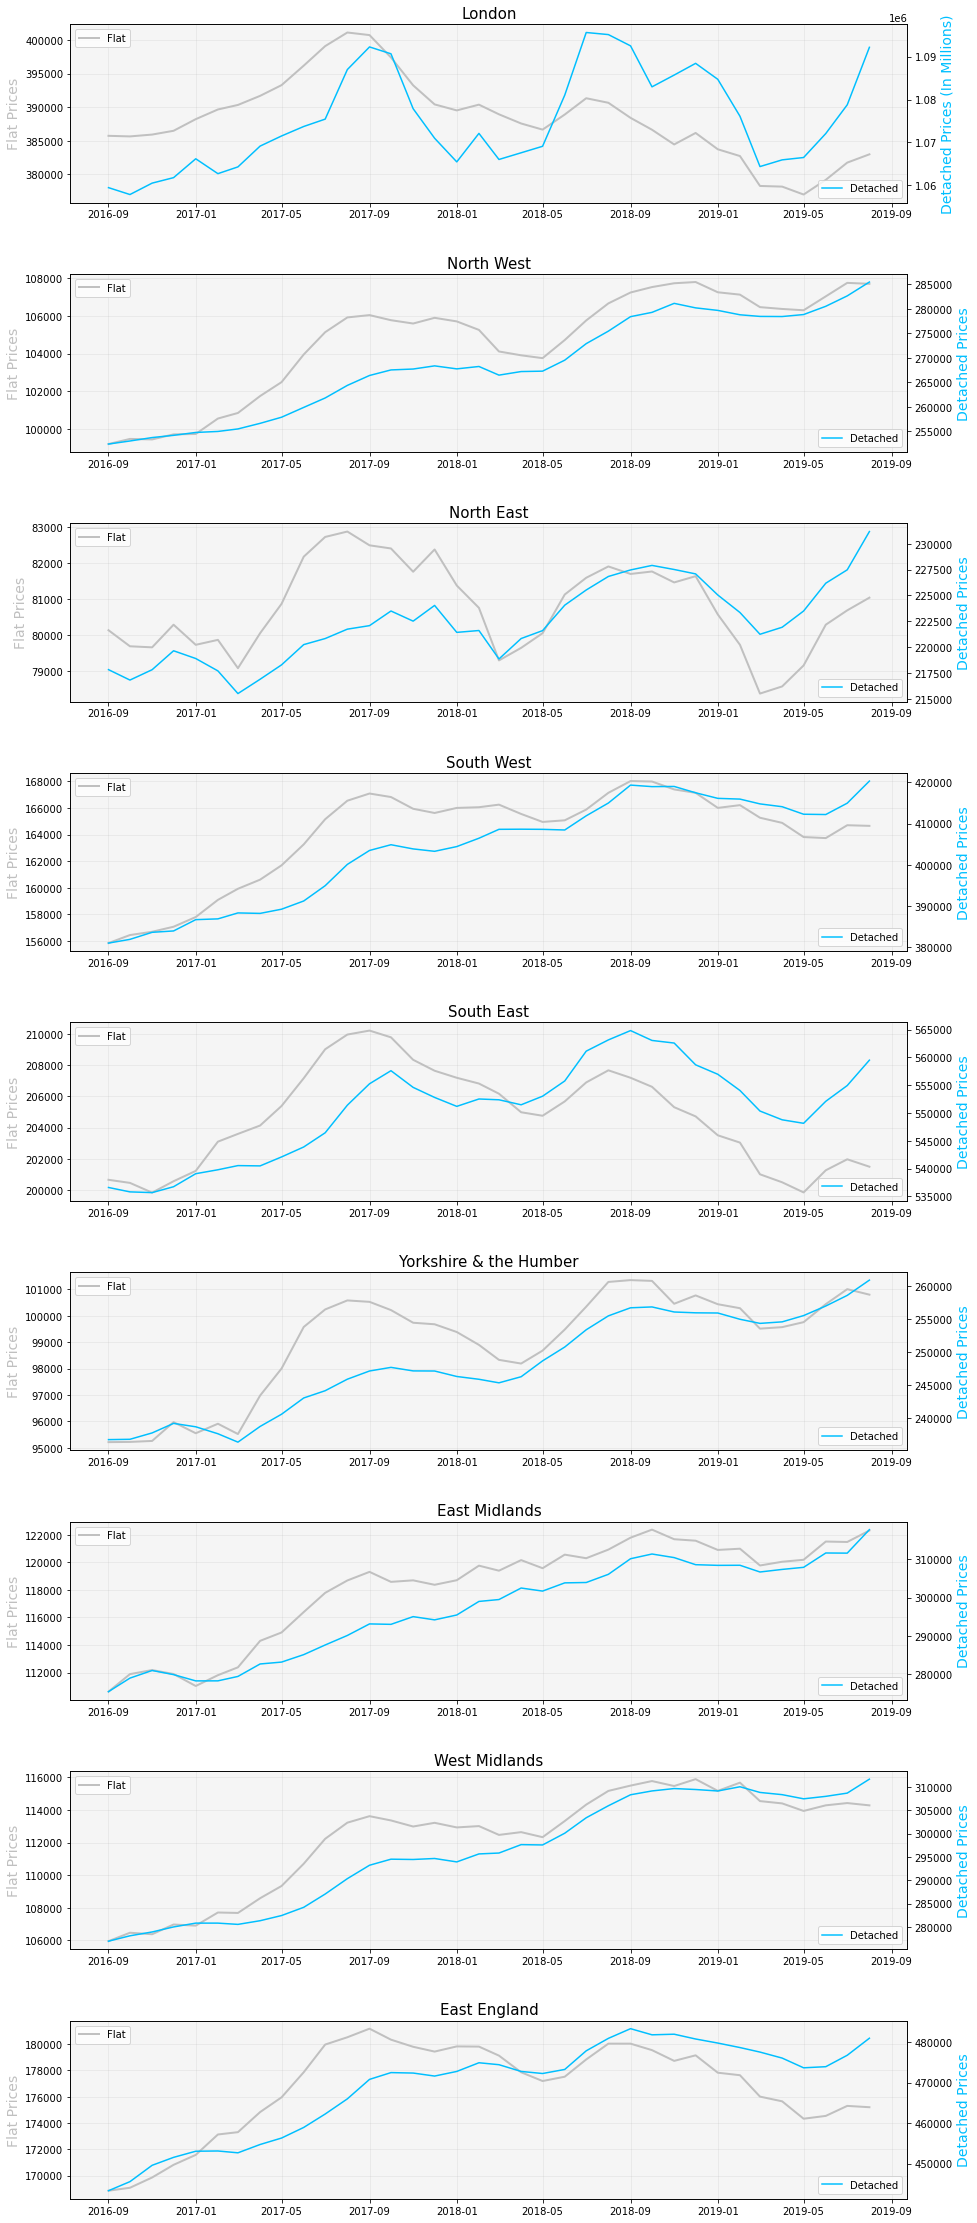

In [17]:
#printing both flat and detached values, comparing both against each other to spot trends
fig, (a1, a2, a3, a4, a5, a6, a7, a8, a9) = plt.subplots(9, 1, figsize=(15, 40))
fig.subplots_adjust(hspace=0.4)

a10 = a1.twinx()
a10.plot(monthlyDetached.loc[:,'London'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a10.set_ylabel('Detached Prices (In Millions)', fontsize=14, color='deepskyblue')
a10.legend(loc = 'lower right')
a1.set_facecolor('whitesmoke')
a1.plot(monthlyFlat.loc[:,'London'], color='silver',linewidth = 2, label = 'Flat')
a1.set_ylabel('Flat Prices', fontsize=14, color='silver')
a1.legend(loc = 'upper left')
a1.set_title('London', fontsize = 15)
a1.grid(alpha = 0.2)

a20 = a2.twinx()
a20.plot(monthlyDetached.loc[:,'NorthWest'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a20.set_ylabel('Detached Prices', fontsize=14, color='deepskyblue')
a20.legend(loc = 'lower right')
a2.set_facecolor('whitesmoke')
a2.plot(monthlyFlat.loc[:,'NorthWest'], color='silver',linewidth = 2, label = 'Flat')
a2.set_ylabel('Flat Prices', fontsize=14, color='silver')
a2.legend(loc = 'upper left')
a2.set_title('North West', fontsize = 15)
a2.grid(alpha = 0.2)

a30 = a3.twinx()
a30.plot(monthlyDetached.loc[:,'NorthEast'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a30.set_ylabel('Detached Prices', fontsize=14, color='deepskyblue')
a30.legend(loc = 'lower right')
a3.set_facecolor('whitesmoke')
a3.plot(monthlyFlat.loc[:,'NorthEast'], color='silver',linewidth = 2, label = 'Flat')
a3.set_ylabel('Flat Prices', fontsize=14, color='silver')
a3.legend(loc = 'upper left')
a3.set_title('North East', fontsize = 15)
a3.grid(alpha = 0.2)

a40 = a4.twinx()
a40.plot(monthlyDetached.loc[:,'SouthWest'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a40.set_ylabel('Detached Prices', fontsize=14, color='deepskyblue')
a40.legend(loc = 'lower right')
a4.set_facecolor('whitesmoke')
a4.plot(monthlyFlat.loc[:,'SouthWest'], color='silver',linewidth = 2, label = 'Flat')
a4.set_ylabel('Flat Prices', fontsize=14, color='silver')
a4.legend(loc = 'upper left')
a4.set_title('South West', fontsize = 15)
a4.grid(alpha = 0.2)

a50 = a5.twinx()
a50.plot(monthlyDetached.loc[:,'SouthEast'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a50.set_ylabel('Detached Prices', fontsize=14, color='deepskyblue')
a50.legend(loc = 'lower right')
a5.set_facecolor('whitesmoke')
a5.plot(monthlyFlat.loc[:,'SouthEast'], color='silver',linewidth = 2, label = 'Flat')
a5.set_ylabel('Flat Prices', fontsize=14, color='silver')
a5.legend(loc = 'upper left')
a5.set_title('South East', fontsize = 15)
a5.grid(alpha = 0.2)

a60 = a6.twinx()
a60.plot(monthlyDetached.loc[:,'Yorkshire'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a60.set_ylabel('Detached Prices', fontsize=14, color='deepskyblue')
a60.legend(loc = 'lower right')
a6.set_facecolor('whitesmoke')
a6.plot(monthlyFlat.loc[:,'Yorkshire'], color='silver',linewidth = 2, label = 'Flat')
a6.set_ylabel('Flat Prices', fontsize=14, color='silver')
a6.legend(loc = 'upper left')
a6.set_title('Yorkshire & the Humber', fontsize = 15)
a6.grid(alpha = 0.2)

a70 = a7.twinx()
a70.plot(monthlyDetached.loc[:,'EastMidlands'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a70.set_ylabel('Detached Prices', fontsize=14, color='deepskyblue')
a70.legend(loc = 'lower right')
a7.set_facecolor('whitesmoke')
a7.plot(monthlyFlat.loc[:,'EastMidlands'], color='silver',linewidth = 2, label = 'Flat')
a7.set_ylabel('Flat Prices', fontsize=14, color='silver')
a7.legend(loc = 'upper left')
a7.set_title('East Midlands', fontsize = 15)
a7.grid(alpha = 0.2)

a80 = a8.twinx()
a80.plot(monthlyDetached.loc[:,'WestMidlands'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a80.set_ylabel('Detached Prices', fontsize=14, color='deepskyblue')
a80.legend(loc = 'lower right')
a8.set_facecolor('whitesmoke')
a8.plot(monthlyFlat.loc[:,'WestMidlands'], color='silver',linewidth = 2, label = 'Flat')
a8.set_ylabel('Flat Prices', fontsize=14, color='silver')
a8.legend(loc = 'upper left')
a8.set_title('West Midlands', fontsize = 15)
a8.grid(alpha = 0.2)

a90 = a9.twinx()
a90.plot(monthlyDetached.loc[:,'EastEngland'], color='deepskyblue',linewidth = 1.5, label = 'Detached')
a90.set_ylabel('Detached Prices', fontsize=14, color='deepskyblue')
a90.legend(loc = 'lower right')
a9.set_facecolor('whitesmoke')
a9.plot(monthlyFlat.loc[:,'EastEngland'], color='silver',linewidth = 2, label = 'Flat')
a9.set_ylabel('Flat Prices', fontsize=14, color='silver')
a9.legend(loc = 'upper left')
a9.set_title('East England', fontsize = 15)
a9.grid(alpha = 0.2)

#### What do these graphs tell us?
It seems as though all properties, regardless of the type, have a **Positive Secular Trend with Seasonality**, however to different extents. I was most shocked by property prices in `London`, assuming the prices would be steadily going up which was not the case. London seems to be the most inconsistant in terms of price trends where the graph appeared to be 'Spikey' With big price increased and sudden price drops. The `North East` region also returned similar results. 

In general, prices between detached properties and flats seem to correlate strongly, when one goes up in price, the other is more than likely to also go up. To further confirm this I will be further investigating the Correlation statistic to see exactly how much correlation there is between the two attributes (flats and detached properties) per region.

There seems to be a pattern in the trend where prices decrease during summer months. Maybe this could be justified by thinking of people who would be on holiday during these times, therefore unable to list their houses for sale? Or people would rather not move into a new house during the summer months. 

Now that we have looked at the price trends
#### Corrolation Statistics Between Flat and Detached Properties Per Region:

In [18]:
#looking at corrolation value between flat and detached values
londonCorr = monthlyFlat['London'].corr(monthlyDetached['London'])
northWestCorr = monthlyFlat['NorthWest'].corr(monthlyDetached['NorthWest'])
northEastCorr = monthlyFlat['NorthEast'].corr(monthlyDetached['NorthEast'])
southWestCorr = monthlyFlat['SouthWest'].corr(monthlyDetached['SouthWest'])
southEastCorr = monthlyFlat['SouthEast'].corr(monthlyDetached['SouthEast'])
yorkshireCorr = monthlyFlat['Yorkshire'].corr(monthlyDetached['Yorkshire'])
eastMidlandsCorr = monthlyFlat['EastMidlands'].corr(monthlyDetached['EastMidlands'])
westMidlandsCorr = monthlyFlat['WestMidlands'].corr(monthlyDetached['WestMidlands'])
eastEnglandCorr = monthlyFlat['EastEngland'].corr(monthlyDetached['EastEngland'])

#printing corrolation value between flat and detached values
print(f'The correlation between prices of London flats and detached properties is {round(londonCorr, 2)}\n')
print(f'The correlation between prices of North West flats and detached properties is {round(northWestCorr, 2)}\n')
print(f'The correlation between prices of North East flats and detached properties is {round(northEastCorr, 2)}\n')
print(f'The correlation between prices of South West flats and detached properties is {round(southWestCorr, 2)}\n')
print(f'The correlation between prices of South East flats and detached properties is {round(southEastCorr, 2)}\n')
print(f'The correlation between prices of Yorkshire flats and detached properties is {round(yorkshireCorr, 2)}\n')
print(f'The correlation between prices of East Midlands flats and detached properties is {round(eastMidlandsCorr, 2)}\n')
print(f'The correlation between prices of West Midlands flats and detached properties is {round(westMidlandsCorr, 2)}\n')
print(f'The correlation between prices of East England flats and detached properties is {round(eastEnglandCorr, 2)}\n')

The correlation between prices of London flats and detached properties is 0.32

The correlation between prices of North West flats and detached properties is 0.93

The correlation between prices of North East flats and detached properties is 0.42

The correlation between prices of South West flats and detached properties is 0.86

The correlation between prices of South East flats and detached properties is 0.5

The correlation between prices of Yorkshire flats and detached properties is 0.87

The correlation between prices of East Midlands flats and detached properties is 0.95

The correlation between prices of West Midlands flats and detached properties is 0.93

The correlation between prices of East England flats and detached properties is 0.73



As you can see, there is generally a strong correlation between prices. The closer the statistic is to 1, the stronger the correlation between flat and detached property prices. 

**What can we say from these results?**

 - East Midlands seemed to have the strongest correlation, where if flat prices go up, property prices will almost inevitably follow suit. 
 - London has the least correlation between the two attributes. However, there is still some noticeable correlation, this may be due to the inconsistant price rises / drops. One explanation to this would be that there are many areas within london, and pricing in london varies a lot depending on the area.
 
Now that we have looked at correlation within each region as well as underlying trends, we can proceed to compare correlation across regions, to see if all regions experience the same trend. If they do, then they are all affected by some sort of external factor such as the countries economy or seasonal trends. We are expecting to see strong positive correlation here judging by information from the line graphs. However, heatmaps will give us a more detailed statistical insight as to exactly how much correlation there is between the regions.

#### Below are heat maps looking at price corrolation across regions:

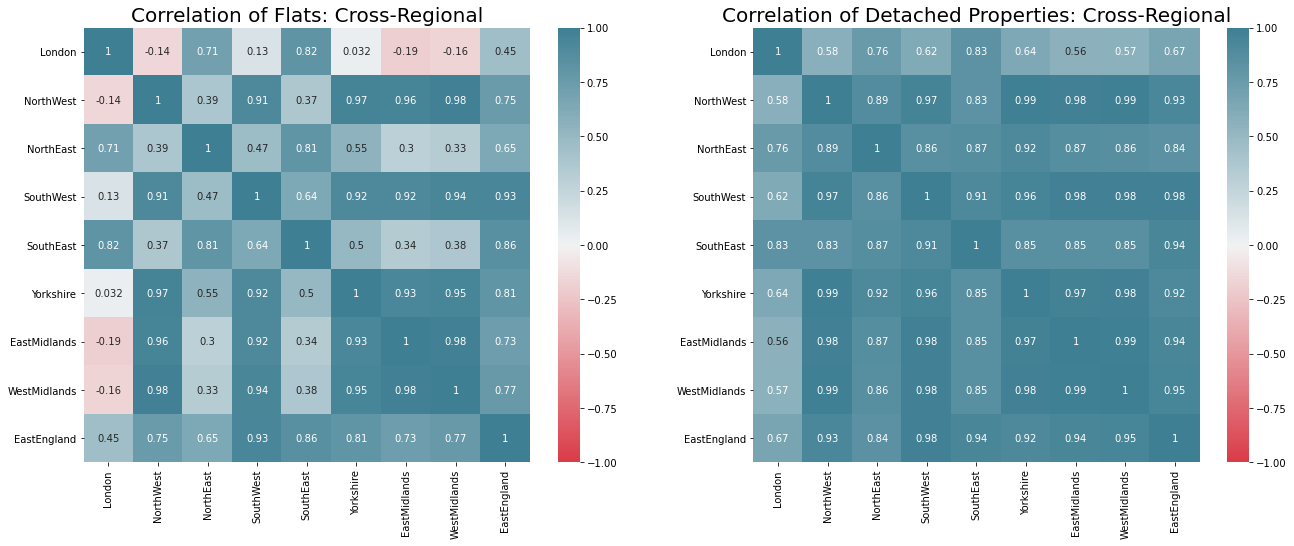

In [19]:
#plotting heatmap to compare regions against each other, seeing a general trend between regions
fig,(a1, a2) = plt.subplots(1, 2, figsize=(22,8))

sns.heatmap(monthlyFlat.corr(), vmin = -1, vmax = 1, cmap = sns.diverging_palette(10, 220, as_cmap=True), 
            annot=True, ax=a1, annot_kws={"size": 10})
a1.set_title('Correlation of Flats: Cross-Regional', fontsize = 20);

sns.heatmap(monthlyDetached.corr(), vmin = -1, vmax = 1, cmap = sns.diverging_palette(10, 220, as_cmap=True), 
            annot=True, ax=a2, annot_kws={"size": 10})
a2.set_title('Correlation of Detached Properties: Cross-Regional', fontsize = 20);

As expected, the correlation across regions is generally strong in `Flat` properties. However, `Detached` property types seem to have even stronger correlation against each other. 

Of all regions, london seems to be the least correlated with the rest, as correlation numbers are relatively low compared to other regions, especially when looking at flat prices:
- `London` against `West Midlands`.
- `London` against `East Midlands`.
- `London` against `Yorkshire`.
- `London` against `South West`.
- `London` against `North West`.

Where correlation seems negligable. To gain better understanding of this, as well as compare seasonal changes between each region. We will now compare all regions against each other using a percent change metric rather then a price difference metric. This makes it easier to plot regions against each other as it normalises the scale of each region regardless of price.

**Notes on Percent Change Graphs:**
 - The percentage should always start at 0 for each of the regions.
 - It should either go up or down relative to price increase or decrease per region.
 
Firstly, we create 2 new tables, 1 which calculates the percent change based on the previous table created which takes the mean monthly price per region by property type. One table will be representative of `Flat` Properties whilst the other will represent `Detached` Property prices. 

To save having to look at identical tables, **I will be displaying the outputs of percent change for only flat properties**, however, the same functions will be applied to the detached properties table.

#### Below is a table looking at percent change of flat properties per month:

In [20]:
#using percent change to plot line graphs against each other on the same scale, regardless of currency.
pctChangeFlats = monthlyFlat.pct_change()

pctChangeDetached = monthlyDetached.pct_change()


pctChangeFlats = pctChangeFlats * 100
pctChangeDetached = pctChangeDetached * 100

pctChangeFlats.head()

,London,NorthWest,NorthEast,SouthWest,SouthEast,Yorkshire,EastMidlands,WestMidlands,EastEngland
Date,,,,,,,,,
2016-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,-0.022651,0.274947,-0.557411,0.387745,-0.098113,0.008812,1.150658,0.488645,0.132223
2016-11-01,0.070938,-0.027088,-0.036905,0.158118,-0.309951,0.038533,0.263623,-0.086174,0.461540
2016-12-01,0.145834,0.271093,0.789962,0.240994,0.363964,0.748033,-0.255443,0.560823,0.566479
2017-01-01,0.446712,0.021212,-0.696263,0.463892,0.328741,-0.438589,-0.778059,-0.064810,0.442042


As you can see, the first row of the table outputted errors. The value should start at 0, however since percent change is based on the mean taken from each month, no data is allocated to the first row. We will replace these **NaN (Not a Number)** values with 0. Before that, we will check to see whether any other errors have come up just in case our calculations were wrong.

#### Below is the sum of errors found under each column / region:

In [21]:
pctChangeFlats.isnull().sum()

London          1
NorthWest       1
NorthEast       1
SouthWest       1
SouthEast       1
Yorkshire       1
EastMidlands    1
WestMidlands    1
EastEngland     1
dtype: int64

no further errors found, we will proceed with replacing these NaN values with 0 and displaying the result.

#### Final percent change table for flat properties (operation assumed to be applied to both):

In [22]:
#replacing NaN values with 0, as they are supposed to start with 0 anyway.
pctChangeFlats = pctChangeFlats.fillna(0)
pctChangeDetached = pctChangeDetached.fillna(0)

pctChangeFlats.head()

,London,NorthWest,NorthEast,SouthWest,SouthEast,Yorkshire,EastMidlands,WestMidlands,EastEngland
Date,,,,,,,,,
2016-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10-01,-0.022651,0.274947,-0.557411,0.387745,-0.098113,0.008812,1.150658,0.488645,0.132223
2016-11-01,0.070938,-0.027088,-0.036905,0.158118,-0.309951,0.038533,0.263623,-0.086174,0.461540
2016-12-01,0.145834,0.271093,0.789962,0.240994,0.363964,0.748033,-0.255443,0.560823,0.566479
2017-01-01,0.446712,0.021212,-0.696263,0.463892,0.328741,-0.438589,-0.778059,-0.064810,0.442042


Now, we will proceed by plotting the cumilative sum of those percentages from all regions to identify the underlying trend.

#### Below is a graph showing percent price change in flat properties:

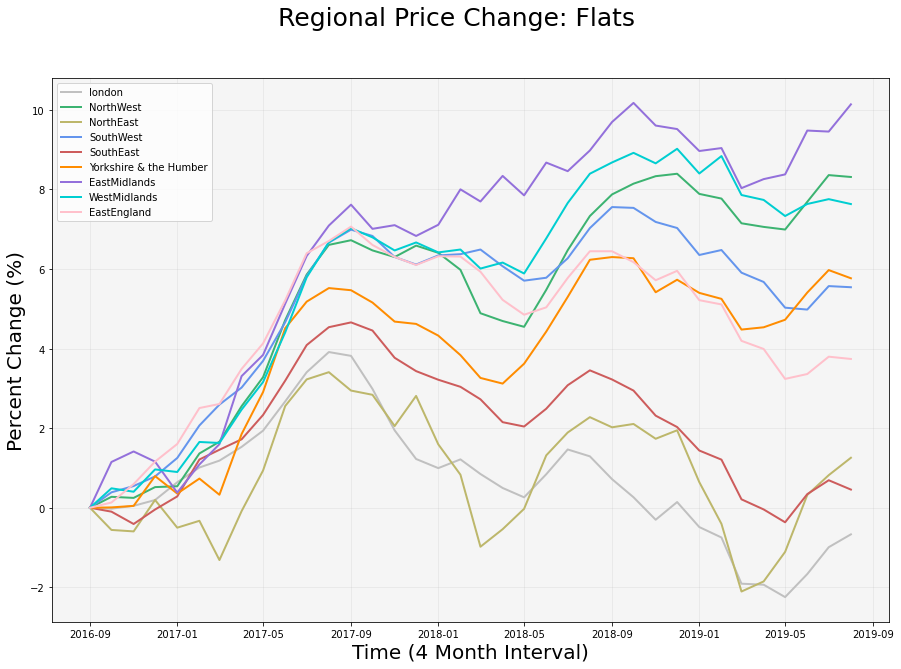

In [23]:
#plotting as is, no smoothing, over the 36 months
#flat properties
fig, ax = plt.subplots(figsize = (15,10))

palette = ['silver', 'mediumseagreen', 'darkkhaki', 'cornflowerblue', 'indianred', 'darkorange', 'mediumpurple', 'darkturquoise', 'pink']

ax.set_facecolor('whitesmoke')
plt.plot(pctChangeFlats['London'].cumsum(), color = palette[0], linewidth = 2, label = 'london')
plt.plot(pctChangeFlats['NorthWest'].cumsum(), color = palette[1], linewidth = 2, label = 'NorthWest')
plt.plot(pctChangeFlats['NorthEast'].cumsum(), color = palette[2], linewidth = 2, label = 'NorthEast')
plt.plot(pctChangeFlats['SouthWest'].cumsum(), color = palette[3], linewidth = 2, label = 'SouthWest')
plt.plot(pctChangeFlats['SouthEast'].cumsum(), color = palette[4], linewidth = 2, label = 'SouthEast')
plt.plot(pctChangeFlats['Yorkshire'].cumsum(), color = palette[5], linewidth = 2, label = 'Yorkshire & the Humber')
plt.plot(pctChangeFlats['EastMidlands'].cumsum(), color = palette[6], linewidth = 2, label = 'EastMidlands')
plt.plot(pctChangeFlats['WestMidlands'].cumsum(), color = palette[7], linewidth = 2, label = 'WestMidlands')
plt.plot(pctChangeFlats['EastEngland'].cumsum(), color = palette[8], linewidth = 2, label = 'EastEngland')
plt.suptitle('Regional Price Change: Flats', fontsize = 25)
plt.ylabel('Percent Change (%)', fontsize = 20)
plt.xlabel('Time (4 Month Interval)', fontsize = 20)
plt.legend(loc = 'upper left')
plt.grid(alpha = 0.2)

This already tells us a lot about the underlying pattern. However, the graph isnt completely clear thus we will be using a rolling mean function. What this basically means is that for every 4 months, the prices are averaged out and plotted as points to connect the line graph. This should smooth out the spikes and give us a better picture of what is going on.

**Note:**
 - Due to taking the mean from each region every 4 months, the first 4 months will not be included in the graph as shown above. However, data from the first 4 months will be used.
 
#### Plotting flat price differences again across regions using rolling mean:

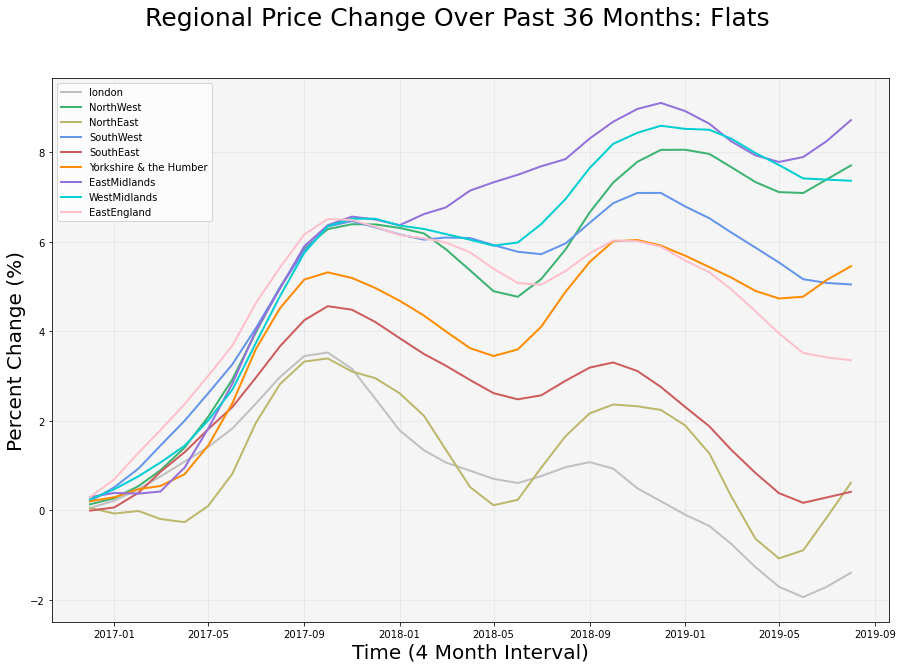

In [24]:
#replotting the graphs, this time with a rolling window of 4, where the mean of every 4 months is calculated and polotted over the 36 months
#flat properties
fig, ax = plt.subplots(figsize = (15,10))

ax.set_facecolor('whitesmoke')
plt.plot(pctChangeFlats['London'].rolling(window=4).mean().cumsum(), color = palette[0], linewidth = 2, label = 'london')
plt.plot(pctChangeFlats['NorthWest'].rolling(window=4).mean().cumsum(), color = palette[1], linewidth = 2, label = 'NorthWest')
plt.plot(pctChangeFlats['NorthEast'].rolling(window=4).mean().cumsum(), color = palette[2], linewidth = 2, label = 'NorthEast')
plt.plot(pctChangeFlats['SouthWest'].rolling(window=4).mean().cumsum(), color = palette[3], linewidth = 2, label = 'SouthWest')
plt.plot(pctChangeFlats['SouthEast'].rolling(window=4).mean().cumsum(), color = palette[4], linewidth = 2, label = 'SouthEast')
plt.plot(pctChangeFlats['Yorkshire'].rolling(window=4).mean().cumsum(), color = palette[5], linewidth = 2, label = 'Yorkshire & the Humber')
plt.plot(pctChangeFlats['EastMidlands'].rolling(window=4).mean().cumsum(), color = palette[6], linewidth = 2, label = 'EastMidlands')
plt.plot(pctChangeFlats['WestMidlands'].rolling(window=4).mean().cumsum(), color = palette[7], linewidth = 2, label = 'WestMidlands')
plt.plot(pctChangeFlats['EastEngland'].rolling(window=4).mean().cumsum(), color = palette[8], linewidth = 2, label = 'EastEngland')
plt.legend(loc = 'upper left')
plt.suptitle('Regional Price Change Over Past 36 Months: Flats', fontsize = 25)
plt.ylabel('Percent Change (%)', fontsize = 20)
plt.xlabel('Time (4 Month Interval)', fontsize = 20)
plt.grid(alpha = 0.2)

#### What does this graph show?
 - Due to the scale of this graph, it is clear to see that there is a seasonal trend in the data, where all regions seem to have a drop in price during the summer seasons every year.
 - Generally, the prices have gone up in most regions but london, which has actually decreased overall by about 1.5% over the 36 month period.
 - All regions seemed to have the greatest incline between around April to August 2017, after the the prices peaked and went down again towards the next summer. 
 - Of all results, East Midlands seems to have increased the most from its original price in september 2016, by around roughly 8.5%.

#### Plotting detached property price differences across regions using rolling mean:

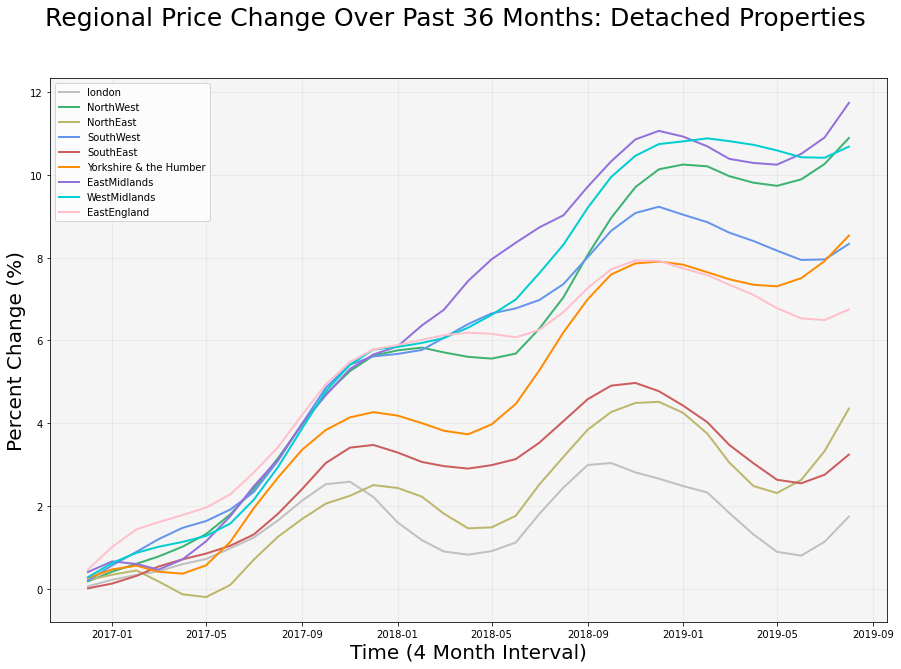

In [25]:
#plotting detached properties
fig, ax = plt.subplots(figsize = (15,10))

ax.set_facecolor('whitesmoke')
plt.plot(pctChangeDetached['London'].rolling(window=4).mean().cumsum(), color = palette[0], linewidth = 2, label = 'london')
plt.plot(pctChangeDetached['NorthWest'].rolling(window=4).mean().cumsum(), color = palette[1], linewidth = 2, label = 'NorthWest')
plt.plot(pctChangeDetached['NorthEast'].rolling(window=4).mean().cumsum(), color = palette[2], linewidth = 2, label = 'NorthEast')
plt.plot(pctChangeDetached['SouthWest'].rolling(window=4).mean().cumsum(), color = palette[3], linewidth = 2, label = 'SouthWest')
plt.plot(pctChangeDetached['SouthEast'].rolling(window=4).mean().cumsum(), color = palette[4], linewidth = 2, label = 'SouthEast')
plt.plot(pctChangeDetached['Yorkshire'].rolling(window=4).mean().cumsum(), color = palette[5], linewidth = 2, label = 'Yorkshire & the Humber')
plt.plot(pctChangeDetached['EastMidlands'].rolling(window=4).mean().cumsum(), color = palette[6], linewidth = 2, label = 'EastMidlands')
plt.plot(pctChangeDetached['WestMidlands'].rolling(window=4).mean().cumsum(), color = palette[7], linewidth = 2, label = 'WestMidlands')
plt.plot(pctChangeDetached['EastEngland'].rolling(window=4).mean().cumsum(), color = palette[8], linewidth = 2, label = 'EastEngland')
plt.legend(loc = 'upper left')
plt.suptitle('Regional Price Change Over Past 36 Months: Detached Properties', fontsize = 25)
plt.ylabel('Percent Change (%)', fontsize = 20)
plt.xlabel('Time (4 Month Interval)', fontsize = 20)
plt.grid(alpha = 0.2)

#### What can we say about the price trends for detached properties?
 - In comparison to flat properties, not only do all prices seem to have gone up this time, but also by a greater percentage. 
 - East midlands sees roughly about a 12% increase in price followed closely by West Midlands and North West regions which have gone up in price by roughly 11%
 - Though london has gone up the least amount, it has still gone up by nearly 2%. This may seem insignificant, but combining this with price data, you could say that the price difference could almost equate to a region region such as yorkshire and the Humber, which has gone up around 8%. This is because London properties are a lot more expensive relative to the other regions in this data. 
 
Further investigating prices, We will now look at the mean price for flat and detached properties in each region over the 36 month period and visualising it, just so we get an idea of how significant the price differences are between the regions.

#### Below is a table comparing the mean price differences of each region:

In [26]:
#looking at the mean region price per region to compare.
meanRegionPrice = pd.DataFrame(data = {'London' : [round(london['Detached'].mean(), 2), round(london['Flat'].mean(), 2)],
                                       'NorthWest' : [round(northWest['Detached'].mean(), 2), round(northWest['Flat'].mean(), 2)],
                                       'NorthEast' : [round(northEast['Detached'].mean(), 2), round(northEast['Flat'].mean(), 2)],
                                       'SouthWest' : [round(southWest['Detached'].mean(), 2), round(southWest['Flat'].mean(), 2)],
                                       'SouthEast' : [round(southEast['Detached'].mean(), 2), round(southEast['Flat'].mean(), 2)],
                                       'Yorkshire' : [round(yorkshire['Detached'].mean(), 2), round(yorkshire['Flat'].mean(), 2)],
                                       'EastMidlands' : [round(eastMidlands['Detached'].mean(), 2), round(eastMidlands['Flat'].mean(), 2)],
                                       'WestMidlands' : [round(westMidlands['Detached'].mean(), 2), round(westMidlands['Flat'].mean(), 2)],
                                       'EastEngland' : [round(eastEngland['Detached'].mean(), 2), round(eastEngland['Flat'].mean(), 2)]}, index = ['Detached', 'Flat']).T
                                         
meanRegionPrice

,Detached,Flat
London,1075111.64,388296.09
NorthWest,268478.22,104659.86
NorthEast,222359.46,80755.14
SouthWest,403860.31,163958.15
SouthEast,550652.39,204660.87
Yorkshire,248198.74,99012.24
EastMidlands,296883.00,118129.27
WestMidlands,296035.19,112249.65
EastEngland,468857.30,176684.51


#### Below are the mean price differences visualised in the form of bar charts:

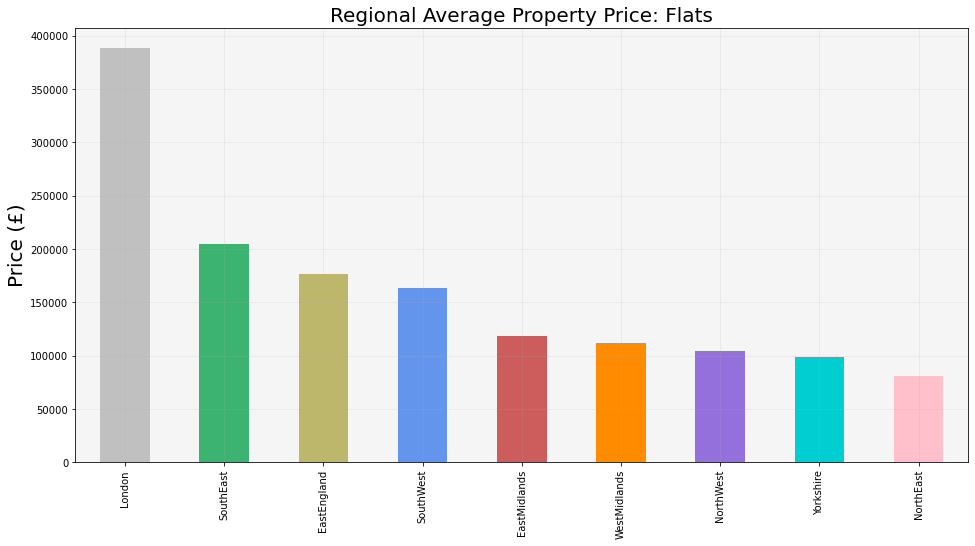

In [27]:
#plotting mean region price for flats, comparing values
fig, ax = plt.subplots(figsize = (16, 8))
fig.subplots_adjust(hspace=0.4)

meanRegionPrice['Flat'].sort_values(ascending = False).plot(kind='bar', color = palette, ax = ax)
ax.set_title('Regional Average Property Price: Flats', fontsize = 20)
ax.set_facecolor('whitesmoke')
ax.set_ylabel('Price (£)', fontsize = 20)
plt.grid(alpha = 0.2);

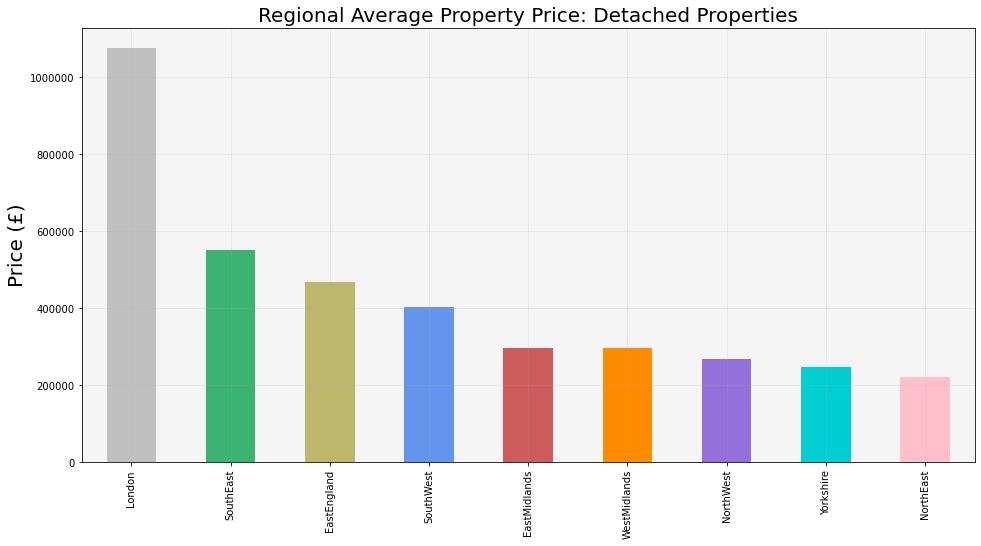

In [28]:
#plotting mean region price for detached, comparing values
fig, ax = plt.subplots(figsize = (16, 8))
fig.subplots_adjust(hspace=0.4)

meanRegionPrice['Detached'].sort_values(ascending = False).plot(kind='bar', color = palette, ax = ax)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
ax.set_facecolor('whitesmoke')
ax.set_title('Regional Average Property Price: Detached Properties', fontsize = 20)
ax.set_ylabel('Price (£)', fontsize = 20)
plt.grid(alpha = 0.2);

#### What do these bar charts tell us?
These bar charts should give a relatively accurate representation of the average pices in each region, where detached and flat properties are compared seperately. From the bar charts, we can see that `London` is by far the most expensive region in the UK. The average property price in london is roughly 4x more expensive than an average property in the `North East`.

Cross referencing these findings, if we take the average price of a property in `London` as £1,150,000 , and take the price increase for detached properties in London as roughly 2%, then compare it to the average price in the `North East` as £220,000 , and take the price increase found for detached properties in the North East as roughly 7%, we would find that the London property has still appreciated more despite only have risen 2% in comparison to 7% (£23,000 price increase in London in comparison to £15,400 in the North East). This should give you an idea of scale when working with percent change.

We also find that generally, property prices in the southern side of England and Lower Midlands are generally higher than properties located in the North.



## Section 4: Visualising Price Differences (Jul 2017 - Jul 2018)
In this section, We will be looking at price differences, particularly Flat property price differences between july 2017 and july 2018. We will first investigate the average price difference by region, then breaking it down by area to see exactly how much each area has gone up / down.

### 4.1 Filtering Data by Date & Formatting
First of all, since we will be strictly looking at flat prices from here on out, we will be removing the detached properties column from our table.
#### Below is what the current table looks like:

In [29]:
#using time stamps to select a date interval
jul2017 = pd.Timestamp(2017,7,1,0)
jul2018 = pd.Timestamp(2018,7,1,0)

#new dataset, flat prices, looking only at flat properties.
flatPrices = propertyPrices.copy()
flatPrices.drop('Detached', axis = 1, inplace = True)

flatPrices

,AreaName,AreaCode,RegionName,RegionCode,Flat
Date,,,,,
2016-09-01,Hartlepool,E06000001,North East,E12000001,62078.21
2016-09-01,Central Bedfordshire,E06000056,East of England,E12000006,165730.04
2016-09-01,Barnet,E09000003,London,E12000007,403337.83
2016-09-01,Dorset,E10000009,South West,E12000009,166286.17
2016-09-01,Dorset,E10000009,South West,E12000009,166286.17
...,...,...,...,...,...
2019-08-01,Shropshire,E06000051,West Midlands,E12000005,117876.59
2019-08-01,Barking and Dagenham,E09000002,London,E12000007,231596.01
2019-08-01,Halton,E06000006,North West,E12000002,78270.11


#### Now, selecting the dates we want to observe, starting off with a table consisting of only 2017-07-01 prices:

In [30]:
#2 new dataframes, each looks at flat property prices on july of either year 2017 or 2018, printing head
flatPrices2017 = flatPrices.loc[jul2017, :]
flatPrices2018 = flatPrices.loc[jul2018, :]

flatPrices2017.head()

,AreaName,AreaCode,RegionName,RegionCode,Flat
Date,,,,,
2017-07-01,Leeds,E08000035,Yorkshire and The Humber,E12000003,128631.00
2017-07-01,Somerset,E10000027,South West,E12000009,127510.14
2017-07-01,Kingston upon Thames,E09000021,London,E12000007,368229.93
2017-07-01,Stoke-on-Trent,E06000021,West Midlands,E12000005,74565.04
2017-07-01,Luton,E06000032,East of England,E12000006,150728.06


#### Table consisting of only 2018-07-01 prices:

In [31]:
flatPrices2018.head()

,AreaName,AreaCode,RegionName,RegionCode,Flat
Date,,,,,
2018-07-01,Newham,E09000025,London,E12000007,350777.19
2018-07-01,Walsall,E08000030,West Midlands,E12000005,107309.73
2018-07-01,Telford and Wrekin,E06000020,West Midlands,E12000005,82471.07
2018-07-01,Reading,E06000038,South East,E12000008,224383.48
2018-07-01,Kingston upon Thames,E09000021,London,E12000007,371306.99


#### Merging the two previous tables using Area as the key value:

In [32]:
#priceDifference dataframe, with 2017 data
priceDifference = pd.DataFrame({'AreaName' : flatPrices2017.loc[:,'AreaName'], 
                                'AreaCode' : flatPrices2017.loc[:, 'AreaCode'],
                               'RegionName' : flatPrices2017.loc[:, 'RegionName'],
                               'RegionCode' : flatPrices2017.loc[:, 'RegionCode'], 
                                'FlatPrices2017' :flatPrices2017.loc[:, 'Flat']})

#merging 2018 prices, such that both values are on the same dataframe.
priceDifference = priceDifference.merge(flatPrices2018)

#renaming column for easier reading
priceDifference.rename(columns = {'Flat':'FlatPrices2018'}, inplace = True)

priceDifference

,AreaName,AreaCode,RegionName,RegionCode,FlatPrices2017,FlatPrices2018
0,Leeds,E08000035,Yorkshire and The Humber,E12000003,128631.00,130194.65
1,Somerset,E10000027,South West,E12000009,127510.14,128228.81
2,Kingston upon Thames,E09000021,London,E12000007,368229.93,371306.99
3,Stoke-on-Trent,E06000021,West Midlands,E12000005,74565.04,74217.05
4,Luton,E06000032,East of England,E12000006,150728.06,144758.97
...,...,...,...,...,...,...
138,Torbay,E06000027,South West,E12000009,132229.98,131116.48
139,Milton Keynes,E06000042,South East,E12000008,155058.80,153846.87
140,Coventry,E08000026,West Midlands,E12000005,118625.08,121004.58
141,Haringey,E09000014,London,E12000007,495335.94,477312.36


#### Adding a `FlatPriceDifference` column which calculates the price difference using: `FlatPrices2018 - FlatPrices2017`

In [33]:
#assigning a new column which calculates the difference between 2017 and 2018 prices
priceDifference = priceDifference.assign(FlatPriceDifference = lambda x: (priceDifference.FlatPrices2018 - priceDifference.FlatPrices2017))
priceDifference

,AreaName,AreaCode,RegionName,RegionCode,FlatPrices2017,FlatPrices2018,FlatPriceDifference
0,Leeds,E08000035,Yorkshire and The Humber,E12000003,128631.00,130194.65,1563.65
1,Somerset,E10000027,South West,E12000009,127510.14,128228.81,718.67
2,Kingston upon Thames,E09000021,London,E12000007,368229.93,371306.99,3077.06
3,Stoke-on-Trent,E06000021,West Midlands,E12000005,74565.04,74217.05,-347.99
4,Luton,E06000032,East of England,E12000006,150728.06,144758.97,-5969.09
...,...,...,...,...,...,...,...
138,Torbay,E06000027,South West,E12000009,132229.98,131116.48,-1113.50
139,Milton Keynes,E06000042,South East,E12000008,155058.80,153846.87,-1211.93
140,Coventry,E08000026,West Midlands,E12000005,118625.08,121004.58,2379.50
141,Haringey,E09000014,London,E12000007,495335.94,477312.36,-18023.58


#### Removing unnecessary clutter, in this case, `RegionCode` and `AreaCode` are not required, nor are `FlatPrices2017` or `FlatPrices2018`

In [34]:
#dropping duplicate and excess columns, no longer needed.
priceDifference.drop(['AreaCode', 'RegionCode', 'FlatPrices2017', 'FlatPrices2018'], axis = 1, inplace = True)
priceDifference

,AreaName,RegionName,FlatPriceDifference
0,Leeds,Yorkshire and The Humber,1563.65
1,Somerset,South West,718.67
2,Kingston upon Thames,London,3077.06
3,Stoke-on-Trent,West Midlands,-347.99
4,Luton,East of England,-5969.09
...,...,...,...
138,Torbay,South West,-1113.50
139,Milton Keynes,South East,-1211.93
140,Coventry,West Midlands,2379.50
141,Haringey,London,-18023.58


Above is an appropriately formatted table, which clearly indicates the price difference of each area between 2017 and 2018. For example: Leeds has gone up by £1,563.65 between July 2017 and July 2018, Leeds is located in Yorkshire and the Humber

### 4.2 Comparing Price Difference By Region

Now that the table is formatted, We can again start by grouping areas by region, and plotting the results. Firstly, I have chosen to visualise the price differences through box plots to begin with, looking at the distribution of prices in areas within regions.

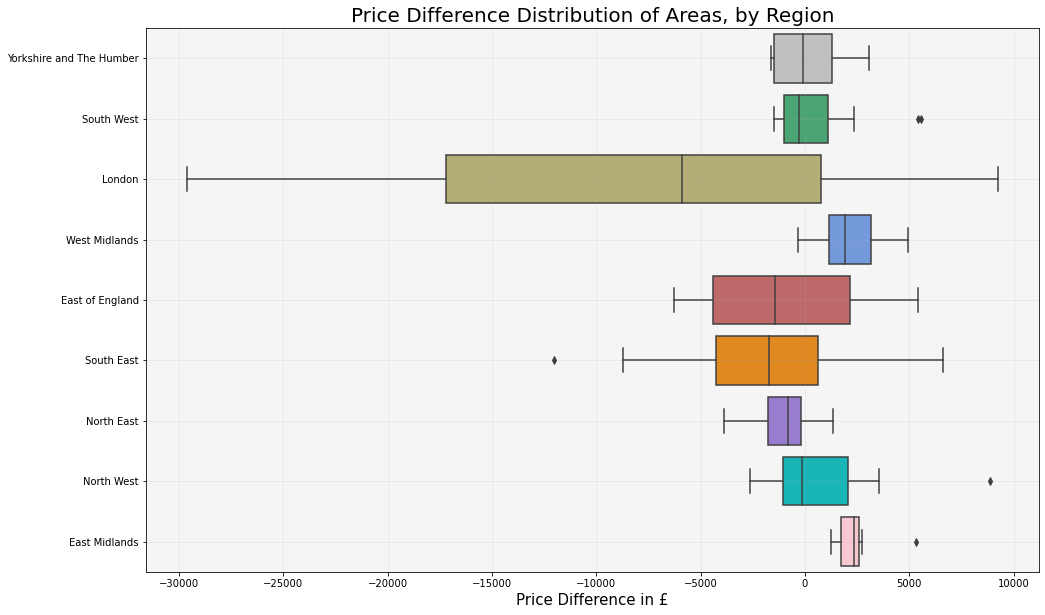

In [35]:
#again grouping this new dataframe by region
region = priceDifference.groupby(by = 'RegionName', dropna = True)


london = region.get_group('London')

northWest = region.get_group('North West')
northEast = region.get_group('North East')

southWest = region.get_group('South West')
southEast = region.get_group('South East')

yorkshire = region.get_group('Yorkshire and The Humber')

eastMidlands = region.get_group('East Midlands')
westMidlands = region.get_group('West Midlands')

eastEngland = region.get_group('East of England')

#plotting box plots for price distribution of areas by region.
fig, ax = plt.subplots(1, 1, figsize=(16,10))
sns.boxplot(x = priceDifference.FlatPriceDifference, y = priceDifference.RegionName, ax = ax, palette = palette)
ax.set_title('Price Difference Distribution of Areas, by Region', fontsize = 20)
ax.set_xlabel('Price Difference in £', fontsize = 15)
ax.set_ylabel('')
ax.set_facecolor('whitesmoke')
plt.grid(alpha = 0.2)

#### What does the box plot tell us?
 - London, by far has the greatest distribution of price differences across all regions. This could be due to 1 of two things:
        - London has the most amount of recorded areas within it (A total of 30 areas within the london region).
        - As touched upon earlier in this document, london is the most expensive region by a significant amount, so though comparative to the others, this distribution of price differences is huge, relative to property costs, it would roughly equate to similar proportions.
 - Most regions have a median score below 0, thus most Regions have suffered some loss in value (though nothing significant).
 - The East Midlands is the only region to have its entire distribution located above 0, meaning all properties in the East Midlands region have gone up. 
 - London has the lowest median score, though is negatively skewed.
 - Most distributions span across £5,000 to £10,000 worth of price difference. 
 
Now to further analyse the distribution of price differences, I will be plotting some histograms with an overlayed density plot to better visualise the distribution. 

#### Histograms of price distributions by region:

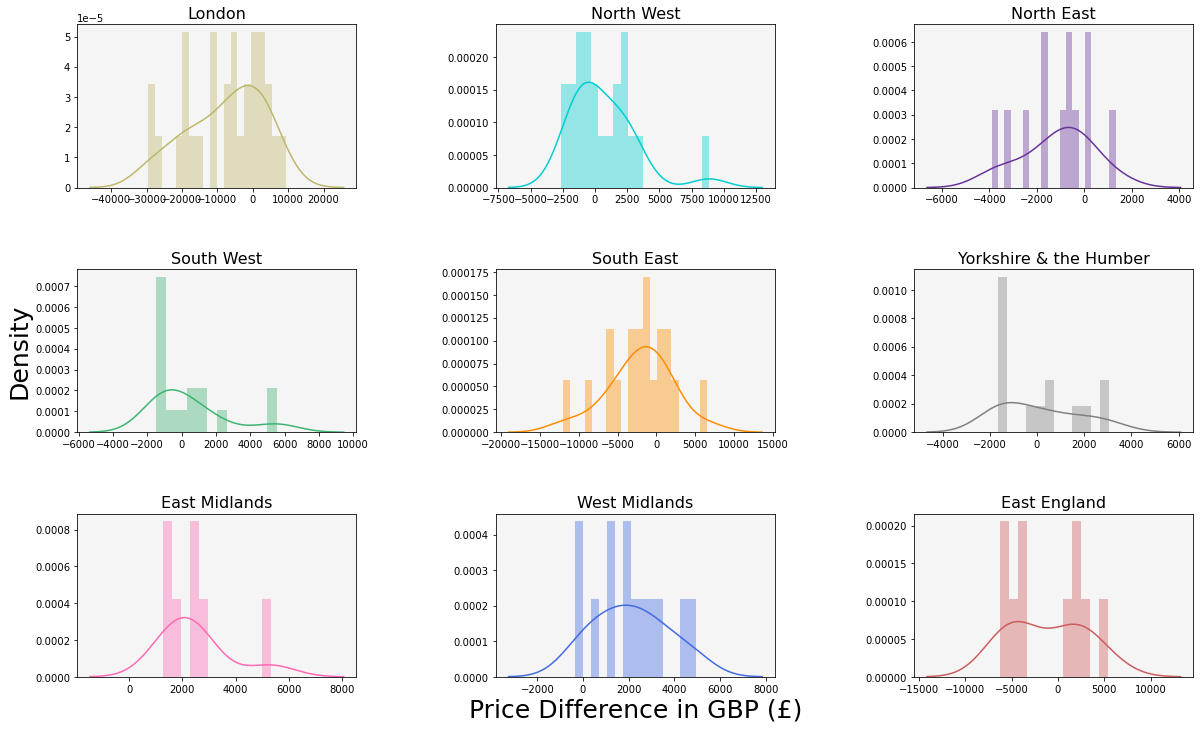

In [36]:
#the following warning supress was used as it is a future warning indicating this method from seaborn libraries will no longer be used
#since this project will be completed and submitted soon, this future warning is ignored. I find it better than the other types it suggests
#as it displays a mean line, helping better understand the underlying distribution / pattern.

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#plotting distributions as histograms to look at each distribution individually
fig, ax = plt.subplots(3,3, figsize = (20,12))
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)

sns.distplot(london['FlatPriceDifference'], color = 'darkkhaki', ax = ax[0,0], bins = 20)
ax[0,0].set_facecolor('whitesmoke')
ax[0,0].set_title('London', fontsize = 16)
ax[0,0].set_ylabel('')
ax[0,0].set_xlabel('')

sns.distplot(northWest['FlatPriceDifference'], color = 'darkturquoise', ax = ax[0,1], bins = 20)
ax[0,1].set_facecolor('whitesmoke')
ax[0,1].set_title('North West', fontsize = 16)
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('')

sns.distplot(northEast['FlatPriceDifference'], color = 'rebeccapurple', ax = ax[0,2], bins = 20)
ax[0,2].set_facecolor('whitesmoke')
ax[0,2].set_title('North East', fontsize = 16)
ax[0,2].set_ylabel('')
ax[0,2].set_xlabel('')

sns.distplot(southWest['FlatPriceDifference'], color = 'mediumseagreen', ax = ax[1,0], bins = 12)
ax[1,0].set_facecolor('whitesmoke')
ax[1,0].set_title('South West', fontsize = 16)
ax[1,0].set_ylabel('Density', fontsize = 25)
ax[1,0].set_xlabel('')

sns.distplot(southEast['FlatPriceDifference'], color = 'darkorange', ax = ax[1,1], bins = 20)
ax[1,1].set_facecolor('whitesmoke')
ax[1,1].set_title('South East', fontsize = 16)
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('')

sns.distplot(yorkshire['FlatPriceDifference'], color = 'grey', ax = ax[1,2], bins = 12)
ax[1,2].set_facecolor('whitesmoke')
ax[1,2].set_title('Yorkshire & the Humber', fontsize = 16)
ax[1,2].set_ylabel('')
ax[1,2].set_xlabel('')

sns.distplot(eastMidlands['FlatPriceDifference'], color = 'hotpink', ax = ax[2,0], bins = 12)
ax[2,0].set_facecolor('whitesmoke')
ax[2,0].set_title('East Midlands', fontsize = 16)
ax[2,0].set_ylabel('')
ax[2,0].set_xlabel('')

sns.distplot(westMidlands['FlatPriceDifference'], color = 'royalblue', ax = ax[2,1], bins = 15)
ax[2,1].set_facecolor('whitesmoke')
ax[2,1].set_title('West Midlands', fontsize = 16)
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel('Price Difference in GBP (£)', fontsize = 25)

sns.distplot(eastEngland['FlatPriceDifference'], color = 'indianred', ax = ax[2,2], bins = 12)
ax[2,2].set_facecolor('whitesmoke')
ax[2,2].set_title('East England', fontsize = 16)
ax[2,2].set_ylabel('')
ax[2,2].set_xlabel('');


#### Looking at these distributions:
 - We could say there is a mix of unimodal and bimodal distributions, where regions such as `East England` seem to have a bimodal distribution in comparison to the `West Midlands`
 - Again as mentioned when analysing box plots, `London` seems to have a negative skew to its distribution, where it seems to tail off more so in the negative price differences than the positive onces. 
 - `Yorkshire and the Humber` seems to be relatively evenly distributed, however that could be attributed due to the lack of areas in that particular region. 
 - Again, we can tell that most peaks lie in the negatives of price differences.

Now that we have a clearer picture of the individual regions, we can proceed by plotting all the densities on the same graph. Though this may look a little cluttered, it helps us understand the relationship between each of the regions and whether they all yield similar price differences **between july 2017 and 2018**.

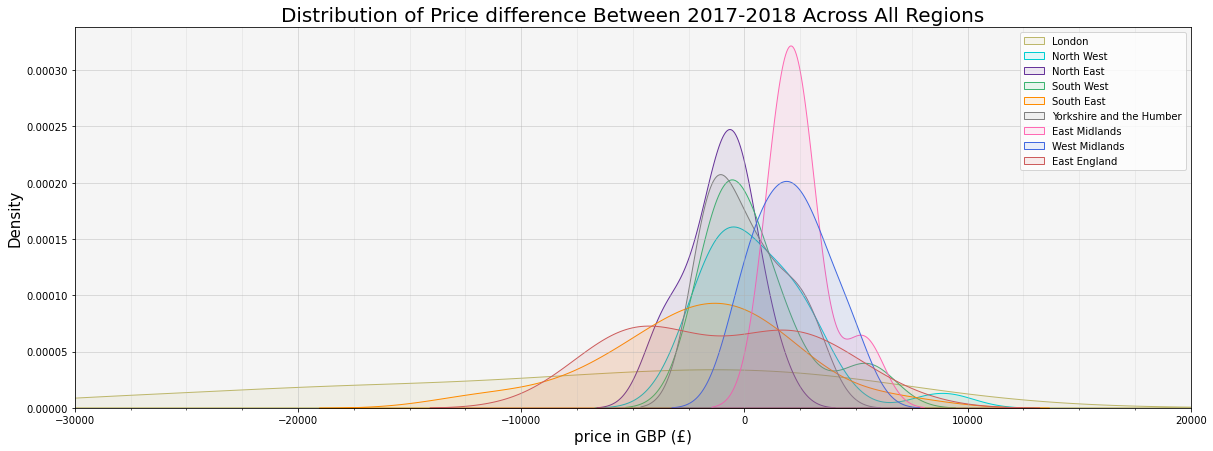

In [37]:
#kde plot looking at the density of price differences in each area, by region.
fig, ax1 = plt.subplots(1, 1, figsize=(20,7))
p = 'FlatPriceDifference'

sns.kdeplot(data=london[p], label='London', ax=ax1, alpha=0.1, shade=True, color = 'darkkhaki')
sns.kdeplot(data=northWest[p], label='North West', ax=ax1, alpha=0.1, shade=True, color = 'darkturquoise')
sns.kdeplot(data=northEast[p], label='North East', ax=ax1, alpha=0.1, shade=True, color = 'rebeccapurple')
sns.kdeplot(data=southWest[p], label='South West', ax=ax1, alpha=0.1, shade=True, color = 'mediumseagreen')
sns.kdeplot(data=southEast[p], label='South East', ax=ax1, alpha=0.1, shade=True, color = 'darkorange')
sns.kdeplot(data=yorkshire[p], label='Yorkshire and the Humber', ax=ax1, alpha=0.1, shade=True, color = 'grey')
sns.kdeplot(data=eastMidlands[p], label='East Midlands', ax=ax1, alpha=0.1, shade=True, color = 'hotpink')
sns.kdeplot(data=westMidlands[p], label='West Midlands', ax=ax1, alpha=0.1, shade=True, color = 'royalblue')
sns.kdeplot(data=eastEngland[p], label='East England', ax=ax1, alpha=0.1, shade=True, color = 'indianred')
ax1.set_facecolor('whitesmoke')

major_ticks = np.arange(-30000, 20000.01, 10000)
minor_ticks = np.arange(-30000, 20000.01, 2500)

ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)

ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)

#labels and formatting, x limit is always adjusted to avoid confusion and only show whats important
ax1.legend()
ax1.set_title('Distribution of Price difference Between 2017-2018 Across All Regions', fontsize = 20)
ax1.set_xlabel('price in GBP (£)', fontsize = 15)
ax1.set_ylabel('Density', fontsize = 15)
ax1.set_xlim(-30000,20000);

#### Looking at the density plot above, we can spot a few things:
 - first of all, the broad distribution of `London` price differences in comparison to other distributions, the density plot for `London` in comparison looks very flat due to how distributed the price differences are.
 - Again, we could tell that the **most common price difference lies just below £0 but falls no further than -£5,000.**
 - For the most part, the **peaks of densities lie between +/- £5,000**. This means that over a year, most properties never really experienced any dramatic price changes and the prices have remained stable over the year.
 - Out of all regions, `East Midlands` **has the highest positive density** meaning most of the flats located in that region have **appreciated between £0 and £5,000.**
 
Now looking at proportions. more specifically, noting whether an area has generally increased or decreased. To work out the proportion, I have created a table which adds up all the areas within a region and calculates it as a proportion of the total amount of areas in a region. The final figure is multiplied by 100 to give us a percentage value, Such that:
 - **Appreciated Proportion = (No. of Areas appreciated in Region / Total No. of Areas in Region) * 100**
 - **Depreciated Proportion = (No. of Areas depreciated in Region / Total No. of Areas in Region) * 100**
 
#### Below is the table showing the proportions:

In [38]:
#calculating proportion of number of properties appreciated vs depreciated in each region.
def calcProportions(region):
    positive = region.loc[region['FlatPriceDifference'] >= 0]
    negative = region.loc[region['FlatPriceDifference'] < 0]
    rPositive = (len(positive) / (len(positive) + len(negative)))
    rNegative = 1 - rPositive
    
    return rPositive, rNegative

londonPos, londonNeg = calcProportions(london)
northWestPos, northWestNeg = calcProportions(northWest)
northEastPos, northEastNeg = calcProportions(northEast)
southWestPos, southWestNeg = calcProportions(southWest)
southEastPos, southEastNeg = calcProportions(southEast)
yorkshirePos, yorkshireNeg = calcProportions(yorkshire)
eastMidlandsPos, eastMidlandsNeg = calcProportions(eastMidlands)
westMidlandsPos, westMidlandsNeg = calcProportions(westMidlands)
eastEnglandPos, eastEnglandNeg = calcProportions(eastEngland)

regionProportions = pd.DataFrame({'London': [londonPos, londonNeg],
                                 'NorthWest': [northWestPos, northWestNeg],
                                 'NorthEast': [northEastPos, northEastNeg],
                                 'SouthWest': [southWestPos, southWestNeg],
                                 'SouthEast': [southEastPos, southEastNeg],
                                 'Yorkshire': [yorkshirePos, yorkshireNeg],
                                 'EastMidlands': [eastMidlandsPos, eastMidlandsNeg],
                                 'WestMidlands': [westMidlandsPos, westMidlandsNeg],
                                 'EastEngland': [eastEnglandPos, eastEnglandNeg]}).round(2).T

regionProportions.rename(columns = {0 : 'Appreciated', 1 : 'Depreciated'}, inplace = True)

#multiplied by 100 to give a percentage
regionProportions = regionProportions * 100

regionProportions

,Appreciated,Depreciated
London,30.0,70.0
NorthWest,50.0,50.0
NorthEast,25.0,75.0
SouthWest,44.0,56.0
SouthEast,32.0,68.0
Yorkshire,50.0,50.0
EastMidlands,100.0,0.0
WestMidlands,85.0,15.0
EastEngland,50.0,50.0


#### Using the proportions, A bar chart was created to help visualise the statistics:

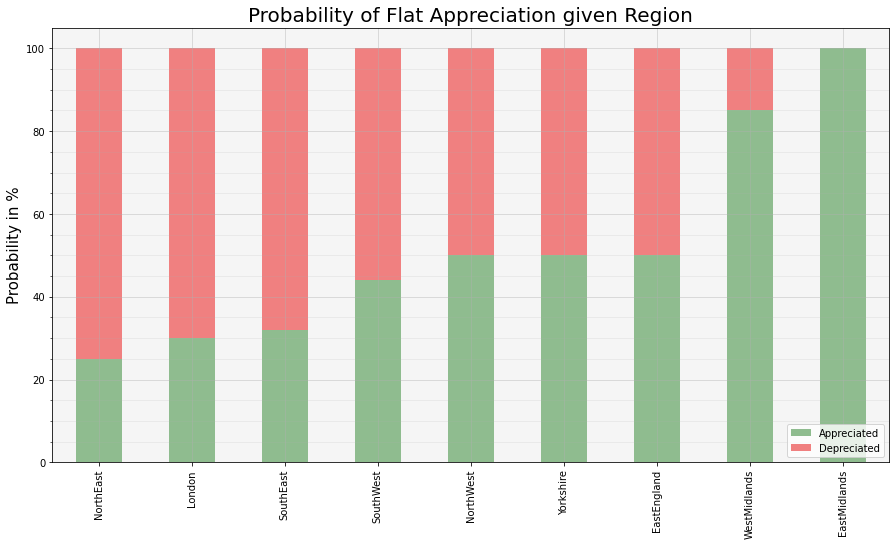

In [39]:
#plotting the proportions
fig, ax = plt.subplots(figsize = (15,8))

regionProportions.sort_values(by = 'Appreciated').plot(kind='bar', color = ['darkseagreen', 'lightcoral'], ax = ax, stacked = True)
plt.legend(loc = 'lower right')
ax.set_title('Probability of Flat Appreciation given Region', fontsize = 20)
ax.set_facecolor('whitesmoke')
ax.set_ylabel('Probability in %', fontsize = 15)

major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 101, 5)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.show()

Proportions are a good way to compare the regions without using price as the factor. This means that we can compare the regions like-for-like in terms of disregarding how expensive an area is, and looking at generally how well it is cope-ing.

#### What can the proportions tell us?

 - It seems as though `North East` was even worse than london in terms of proportion of depreciated price differences, where only 25% of properties actually appreciated given that region.
 - All flat properties in `East Midlands` have appreciated.
 - Appart for the `North East`, it seems like there is a general trend where all areas in the Midlands and above seem to do better in terms of appreciating in value.

### Section 4.2: Comparing Price Difference By Area

Now that we have broken down the price differences by region, I will proceed by analysing the areas within each region. This can be considered as more in-depth as we look at the depreciation / appreciation value of each area, yet still organised by region for clarity. To visualise this, I have again opted to use bar charts. The difference in price will be stated down the left hand side whilst the bottom is the name of each area within a particular region.

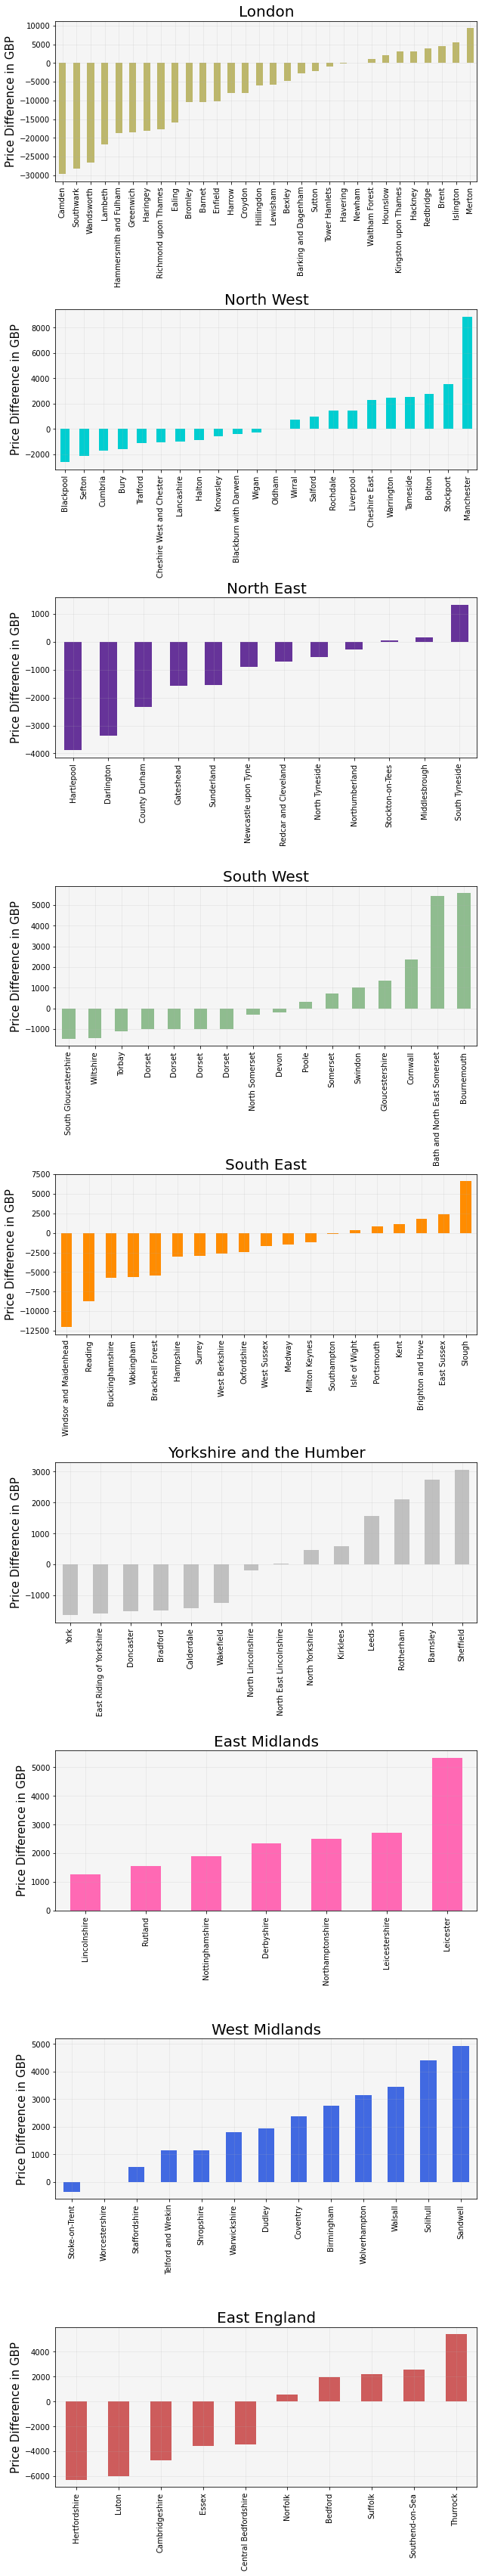

In [40]:
#indexing each region group by area name
l = london.set_index('AreaName')
nw = northWest.set_index('AreaName')
ne = northEast.set_index('AreaName')
sw = southWest.set_index('AreaName')
se = southEast.set_index('AreaName')
yo = yorkshire.set_index('AreaName')
em = eastMidlands.set_index('AreaName')
wm = westMidlands.set_index('AreaName')
ee = eastEngland.set_index('AreaName')

#plotting price appreciation / depreciation of each area by region, so client can inspect each region individually if he / she wishes
fig, (a1,a2,a3,a4,a5,a6,a7,a8,a9) = plt.subplots(9,1, figsize = (10,60))
fig.subplots_adjust(hspace=0.8)

l['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a1, color = 'darkkhaki')
a1.set_facecolor('whitesmoke')
a1.set_title('London', fontsize = 20)
a1.set_ylabel('Price Difference in GBP', fontsize = 15)
a1.set_xlabel('')
a1.grid(alpha = 0.2)

nw['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a2, color = 'darkturquoise')
a2.set_facecolor('whitesmoke')
a2.set_title('North West', fontsize = 20)
a2.set_ylabel('Price Difference in GBP', fontsize = 15)
a2.set_xlabel('')
a2.grid(alpha = 0.2)

ne['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a3, color = 'rebeccapurple')
a3.set_facecolor('whitesmoke')
a3.set_title('North East', fontsize = 20)
a3.set_ylabel('Price Difference in GBP', fontsize = 15)
a3.set_xlabel('')
a3.grid(alpha = 0.2)

sw['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a4, color = 'darkseagreen')
a4.set_facecolor('whitesmoke')
a4.set_title('South West', fontsize = 20)
a4.set_ylabel('Price Difference in GBP', fontsize = 15)
a4.set_xlabel('')
a4.grid(alpha = 0.2)

se['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a5, color = 'darkorange')
a5.set_facecolor('whitesmoke')
a5.set_title('South East', fontsize = 20)
a5.set_ylabel('Price Difference in GBP', fontsize = 15)
a5.set_xlabel('')
a5.grid(alpha = 0.2)

yo['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a6, color = 'silver')
a6.set_facecolor('whitesmoke')
a6.set_title('Yorkshire and the Humber', fontsize = 20)
a6.set_ylabel('Price Difference in GBP', fontsize = 15)
a6.set_xlabel('')
a6.grid(alpha = 0.2)

em['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a7, color = 'hotpink')
a7.set_facecolor('whitesmoke')
a7.set_title('East Midlands', fontsize = 20)
a7.set_ylabel('Price Difference in GBP', fontsize = 15)
a7.set_xlabel('')
a7.grid(alpha = 0.2)

wm['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a8, color = 'royalblue')
a8.set_facecolor('whitesmoke')
a8.set_title('West Midlands', fontsize = 20)
a8.set_ylabel('Price Difference in GBP', fontsize = 15)
a8.set_xlabel('')
a8.grid(alpha = 0.2)

ee['FlatPriceDifference'].sort_values().plot(kind = 'bar', ax = a9, color = 'indianred')
a9.set_facecolor('whitesmoke')
a9.set_title('East England', fontsize = 20)
a9.set_ylabel('Price Difference in GBP', fontsize = 15)
a9.set_xlabel('')
a9.grid(alpha = 0.2)


These findings are relatively self explanatory, thus it is clear to see the price difference to the corresponding area within each region. In terms of price differences, this bar chart clearly illustrates figures where we can tell the absolute range of price differences within a region. 

For example, in `Yorkshire and the Humber`, York is the area which depreciated most in price at around -£1,500 whereas Sheffield appreciated the most at around +£3,000. 

These bar charts also visualise the proportions of appreciated / depreciated values in each area, where you can clearly tell where the bars go negative. It is especially clear to see this in the London region due to the amount of areas in London.

Below, I have visualised the same information in a slightly different manner. I have created a new column named `Value` which detects whether a pricedifference is positive or negative, and returns increased (In green) or decreased (In red). This table shows more precise price information in comparison to the bar chart above. I have displayed only the `London` region as an example, but more can be provided upon request:

In [41]:
#adding an increased or decreased value column to the dataframe of each region
def trueOrFalse(regionPrice):
    posORneg = []
    for i in regionPrice:
        if i >= 0:
            posORneg.append('Increased')
        else:
            posORneg.append('Decreased')
    return posORneg

#adding a visual element to the dataframe, making it easier to spot price increase vs decrease
def color_positive_green(val): 
    """ 
    Takes a scalar and returns a string with 
    the css property `'color: green'` for positive 
    strings, black otherwise. 
    """
    if val == 'Increased': 
        color = 'green'
    elif val == 'Decreased': 
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color 

#applying the functions to each region. since the data is grouped by region, the region name can be dropped.
london = london.assign(Value = trueOrFalse(london.FlatPriceDifference)).round(2)
london.drop(['RegionName'], axis = 1, inplace = True)
london_col = london.style.applymap(color_positive_green)

northWest = northWest.assign(Value = trueOrFalse(northWest.FlatPriceDifference)).round(2)
northWest.drop(['RegionName'], axis = 1, inplace = True)
northWest_col = northWest.style.applymap(color_positive_green)

northEast = northEast.assign(Value = trueOrFalse(northEast.FlatPriceDifference)).round(2)
northEast.drop(['RegionName'], axis = 1, inplace = True)
northEast_col = northEast.style.applymap(color_positive_green)


southWest = southWest.assign(Value = trueOrFalse(southWest.FlatPriceDifference)).round(2)
southWest.drop(['RegionName'], axis = 1, inplace = True)
southWest_col = southWest.style.applymap(color_positive_green)


southEast = southEast.assign(Value = trueOrFalse(southEast.FlatPriceDifference)).round(2)
southEast.drop(['RegionName'], axis = 1, inplace = True)
southEast_col = southEast.style.applymap(color_positive_green)


yorkshire = yorkshire.assign(Value = trueOrFalse(yorkshire.FlatPriceDifference)).round(2)
yorkshire.drop(['RegionName'], axis = 1, inplace = True)
yorkshire_col = yorkshire.style.applymap(color_positive_green)


eastMidlands = eastMidlands.assign(Value = trueOrFalse(eastMidlands.FlatPriceDifference)).round(2)
eastMidlands.drop(['RegionName'], axis = 1, inplace = True)
eastMidlands_col = eastMidlands.style.applymap(color_positive_green)


westMidlands = westMidlands.assign(Value = trueOrFalse(westMidlands.FlatPriceDifference)).round(2)
westMidlands.drop(['RegionName'], axis = 1, inplace = True)
westMidlands_col = westMidlands.style.applymap(color_positive_green)


eastEngland = eastEngland.assign(Value = trueOrFalse(eastEngland.FlatPriceDifference)).round(2)
eastEngland.drop(['RegionName'], axis = 1, inplace = True)
eastEngland_col = eastEngland.style.applymap(color_positive_green)

In [42]:
#1 example of increased / decreased table

print('############\nLondon\n############')
london_col

############
London
############


,AreaName,FlatPriceDifference,Value
2,Kingston upon Thames,3077.060000,Increased
6,Wandsworth,-26692.200000,Decreased
9,Harrow,-8059.990000,Decreased
14,Richmond upon Thames,-17636.880000,Decreased
23,Hammersmith and Fulham,-18643.200000,Decreased
29,Newham,2.790000,Increased
32,Brent,4473.720000,Increased
39,Hillingdon,-5931.390000,Decreased
40,Southwark,-28147.330000,Decreased
48,Lewisham,-5865.970000,Decreased


## 5 Chi Squared
In this section, we will be using a Chi Squared test to investigate whether regions can be treated as independant variables based on a contingency table we formulate, or whether our results indicate that region price differences are somehow connected such that:
 - If London increases in price, so does the North West (For example).

### 5.1 Looking at the statistics
 
So carrying on from section 4, we will be looking at the number of increased and decreased areas within each region using the `Values` column. The results will be formatted into a new contingency table.

#### Below is the contingency table created:

In [43]:
#grouping each region by value column added in previous section
valLDN = london.groupby(by = 'Value', dropna = True)
valNW = northWest.groupby(by = 'Value', dropna = True)
valNE = northEast.groupby(by = 'Value', dropna = True)
valSW = southWest.groupby(by = 'Value', dropna = True)
valSE = southEast.groupby(by = 'Value', dropna = True)
valYO = yorkshire.groupby(by = 'Value', dropna = True)
valEM = eastMidlands.groupby(by = 'Value', dropna = True)
valWM = westMidlands.groupby(by = 'Value', dropna = True)
valEE = eastEngland.groupby(by = 'Value', dropna = True)

#using the length of increased / decreased to work out the total number of appreciated properties in each region
crosstabRegions = pd.DataFrame({'London': [len(valLDN.get_group('Increased')), len(valLDN.get_group('Decreased'))], 
                           'NorthWest': [len(valNW.get_group('Increased')), len(valNW.get_group('Decreased'))],
                          'NorthEast': [len(valNE.get_group('Increased')), len(valNE.get_group('Decreased'))],
                          'SouthWest': [len(valSW.get_group('Increased')), len(valSW.get_group('Decreased'))],
                          'SouthEast': [len(valSE.get_group('Increased')), len(valSE.get_group('Decreased'))],
                          'Yorkshire': [len(valYO.get_group('Increased')), len(valYO.get_group('Decreased'))],
                          'EastMidlands': [len(valEM.get_group('Increased')), 0],
                          'WestMidlands': [len(valWM.get_group('Increased')), len(valWM.get_group('Decreased'))],
                          'EastEngland': [len(valEE.get_group('Increased')), len(valEE.get_group('Decreased'))]},
                         index = ['Increased', 'Decreased'])

#printing new dataframe
crosstabRegions

,London,NorthWest,NorthEast,SouthWest,SouthEast,Yorkshire,EastMidlands,WestMidlands,EastEngland
Increased,9,11,3,7,6,7,7,11,5
Decreased,21,11,9,9,13,7,0,2,5


**A Chi Squared test will now be operated on the table above to calculate:**
 - The degrees of freedom (based on rows and columns of table)
 - The Chi-Squared statistic (A calculation using the proportions)
 - The P-Value (A distribution figure we can use to decide whether to accept or reject the null hypothesis)

**Previous analysis in this document indicates that all regions seem to have generally gone up, but have the gone up because of a particular regions' increase in value? or are they all completely independant and it just so happens that by chance or some other variable, all regions have generally gone up in price? Chi-Squared should help us with this investigation.**

**Our hypothosis for this test is as follows:**

We want to find out whether all 9 regions, otherwise known as our independant variables, are somehow linked together. i.e. if `London` Prices increase, so do `North West` Prices. Chi-Squared should help us investigate whether the regions are linked, or whether they are completely independant variables.
 
**When calculating Chi-Squared, we will assume:**
 - The independant variables provided have a normal distribution.
 - Our significance level will be 5% (alpha = 0.05), which will be compared against our P-Value. If the P-Value is larger than 5%, we accept our hypothosis.

#### Below are the results:

In [44]:
#calculating Chi Squared value, degrees of freedom and P-Value
test_stat, p_value, dof, expected = stats.chi2_contingency(crosstabRegions, correction=False)

print('\nThere are %d degrees of freedom' % dof)
print('\nThe chi-squared test statistic is %4.2f' % test_stat)
print('\nThe p-value is %4.3f %%' % (100 * p_value))


There are 8 degrees of freedom

The chi-squared test statistic is 23.15

The p-value is 0.318 %


### 5.2 Visualising Chi Squared & Analysing Our Findings

#### Below is a visualisation of our Chi-Squared curve:

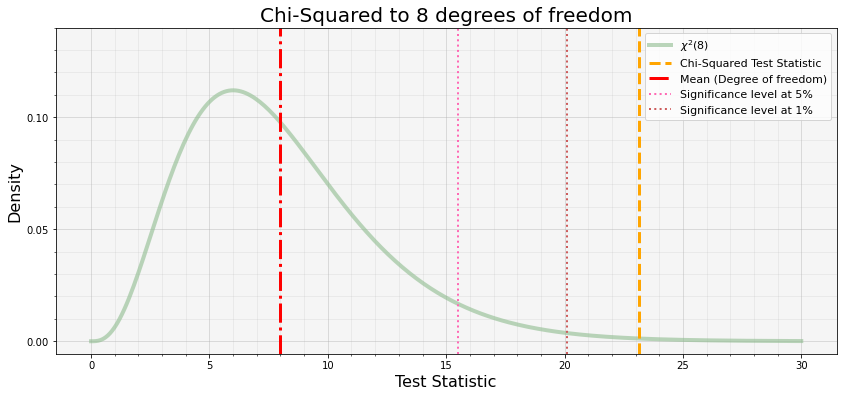

In [45]:
#plotting a chi-squared figure of the degree of freedom suitable for our data
fig, ax = plt.subplots(1, 1, figsize = (14,6))

x = np.linspace(0.0, 30.0, 300)
ax.plot(x, stats.chi2.pdf(x, 8), 'darkseagreen', linewidth=4, alpha=0.6, label='$\chi^2(8)$')
ax.legend(fontsize=16)

#plotting our Chi-Squared test statistic
plt.axvline(x=23.15,  c = 'orange', linestyle = 'dashed', label = 'Chi-Squared Test Statistic', linewidth = 3)
plt.axvline(x=8,  c = 'red', linestyle = '-.', label = 'Mean (Degree of freedom)', linewidth = 3)
plt.axvline(x=15.51,  c = 'hotpink', linestyle = 'dotted', label = 'Significance level at 5%', linewidth = 2)
plt.axvline(x=20.09,  c = 'indianred', linestyle = 'dotted', label = 'Significance level at 1%', linewidth = 2)

ax.set_xlabel('Test Statistic', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
plt.legend(fontsize = 11)


major_ticks = np.arange(0, 30.01, 5)
minor_ticks = np.arange(0, 30.01, 1)

major_ticksy = np.arange(0, 0.15, 0.05)
minor_ticksy = np.arange(0, 0.15, 0.01)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set_yticks(major_ticksy)
ax.set_yticks(minor_ticksy, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_facecolor('whitesmoke')
ax.set_title('Chi-Squared to 8 degrees of freedom', fontsize = 20);

**This graph shows:**
 - The Chi-Squared curve
 - The Mean
 - Significance levels at 5% and 1% (also known as Alpha).
 - Visualises our Chi-Squared Statistic. As can be seen from the graph, it is quite distant from the mean. Our Chi-Squared statistic represents data to the right of the vertical line and under the curve (very insignificant amount of data).

**What does the degree of freedom tell us?**
 - The degree of freedom is the mean of the chi-squared distribution curve associated with our data. In this case, **The mean is 8**.
 - The further away our test statistic is from the mean, the less likely that there are similarities between the variables proportionaly. In this case, our test statistic was 23.15
 
**What does the Chi-Squared Test Statistic tell us?**
 - Chi-Squared allows us to see how multiple independant variables interact.
 - Our result was **23.15**. When comparing this to the Chi-Squared table, we find that this value falls below our 5% significance level.
 - This suggests we reject our null hypothesis of the variables being dependant on each other, meaning the Regions are truely independant.
 
**What does our P-value tell us?**
 - The P-value will tell us the probability percentage of our variables (regions) being dependant, i.e. one change in a region would cause the other.
 - In this case our p-value was **0.318%**, which indicates that the chance of these events recurring is **extremely insignificant**.
 
**What are the limitations of a Chi-Squared Test?**
 - Though this informs us of the similarity between the variables, it does not tell us exactly how dis-similar the variables are.
 - Expanding on the previous point, chi-squared tests are very sensitive to sample/ data sizes. If a sample is small, reasonably strong connections may not come up as significant.
 - If another sample was chosen from a different year, these results may vary, and the null hypothesis could be accepted in such scenario.
 - The significance level is defined before carrying out the test, and could vary depending on what we are trying to establish and to what extent. Though 5% is commonly used and is what is used in our situation, 1% or 10% could also be used as thresholds. 
 - It does not inform us of whether 2 of the 9 regions generally are dependant to some extent more than others, but gives us a general picture of all regions. i.e. it lacks in specific details.
 
**Conclusive Findings:**
 - The regions are independant of each other. This means that regardless of price in a particular region, prices would remain unaffected in others. 
 - Prices between July 2017 and 2018 seem to have generally gone up.
 - Prices are affected by season.
 - London is by far the most expensive region.
 - London has the broadest range of price differences of all regions.